# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

- **User_input**: user inputs tokenized without preprocessing
- **User_input_preprocessed**: user inputs tokenized with preprocessing
- **User_input_preprocessed_stem**: user inputs tokenized with preprocessing and stemming
- **User_input_preprocessed_lem** : user inputs tokenized with preprocessing and lematization

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, log_loss
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import joblib
from nltk.corpus import stopwords
from wordcloud import WordCloud
from hyperopt import hp, fmin, tpe, Trials, space_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from joblib import Parallel, delayed


#### Run with GPU


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Data Load

In [26]:
datapath = "Data/dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [4]:
display(data)

Disease                                         User_input
0       Psoriasis  I have been experiencing a skin rash on my arm...
1       Psoriasis  My skin has been peeling, especially on my kne...
2       Psoriasis  I have been experiencing joint pain in my fing...
3       Psoriasis  There is a silver like dusting on my skin, esp...
4       Psoriasis  My nails have small dents or pits in them, and...
...           ...                                                ...
10329  Dermatitis  The discomfort in my skin has made it challeng...
10330  Dermatitis  The raw, sensitive skin from scratching has ma...
10331  Dermatitis  I feel like my skin is tearing apart, causing ...
10332  Dermatitis  Engaging in physical activities has become unb...
10333  Dermatitis  The pain in my skin has restricted me from enj...

[10334 rows x 2 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10334 entries, 0 to 10333
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     10334 non-null  object
 1   User_input  10334 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [6]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 10334 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


Psoriasis : 2113 samples
Melanoma : 2070 samples
Urticaria : 2216 samples
Lupus : 1669 samples
Dermatitis : 2266 samples


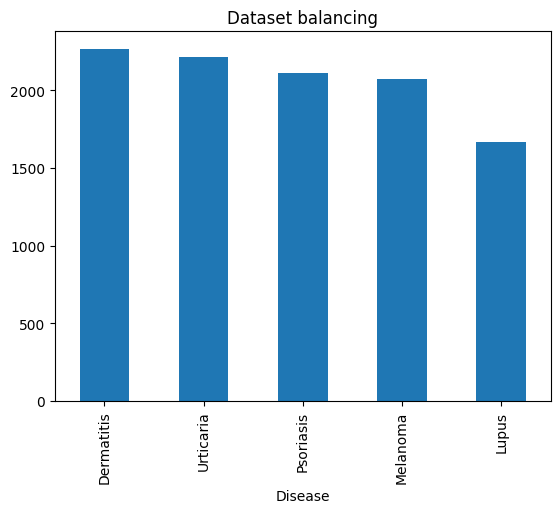

In [7]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

# Print count for each disease
for disease in data['Disease'].unique():
    print(f"{disease} : {data[data['Disease'] == disease].shape[0]} samples")

## Model Evaluation

In [27]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    print("\033[1mTraining Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

    # Test
    y_test_pred = model.predict(X_Test)
    print("\n\033[1mTesting Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

    # Loss
    print("\n\033[1mLoss\033[0m")
    y_pred_proba = model.predict_proba(X_Test)
    # Calculate the log loss
    loss = log_loss(y_test, y_pred_proba)
    print(f"Log loss: {loss}")

    # Classification report train
    print("\n\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\n\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()

    #return test f1score
    return f1_score(y_test, y_test_pred, average='weighted')


def evaluate_dp(model, history, X, Y):
    print("\n\033[1mTesting Results\033[0m")
    loss, accuracy = model.evaluate(X, Y, verbose=-1)
    print("Loss: ", loss)
    print("Accuracy: ", accuracy)

    figure_dp, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'])
    ax1.plot()

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'])
    ax2.plot()


## Text Preprocessing

In [28]:
data['User_input_preprocessed'] = data['User_input']

- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [29]:
# Load english stop words using stopwords
# nltk.download('stopwords')

# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')


## Data Visualization

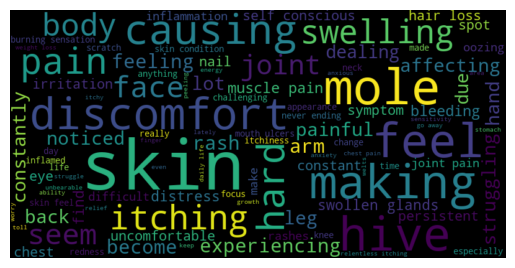

In [11]:
# General word cloud
word_list = " ".join(text for text in data['User_input'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

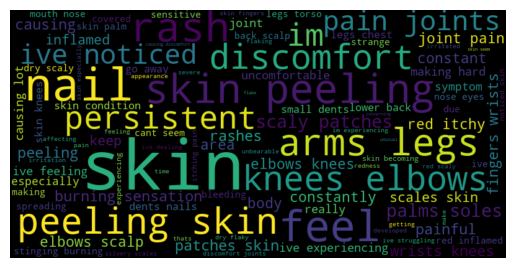

In [12]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

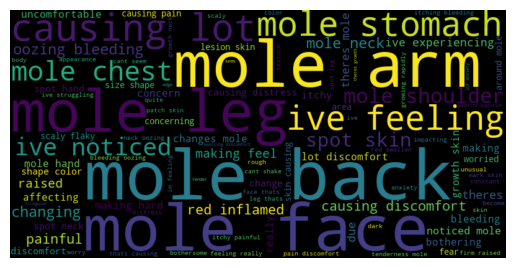

In [13]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

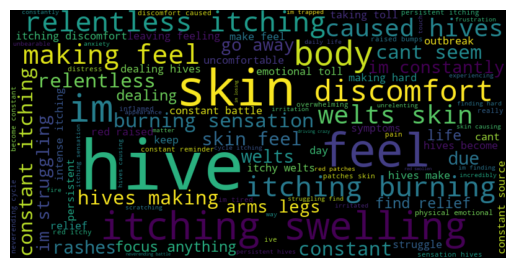

In [14]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

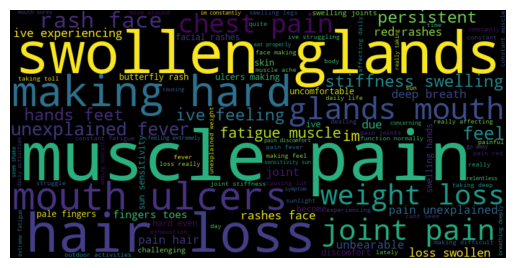

In [15]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

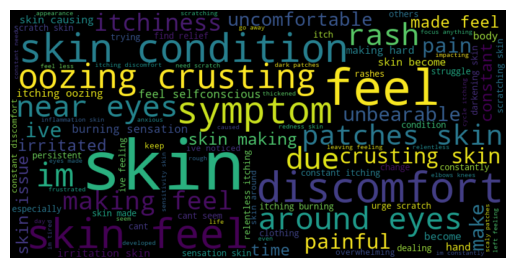

In [16]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenization

In [17]:
# Tokenization by white space
#tokenizer = nltk.tokenize.WhitespaceTokenizer()
#data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
#tokenizer = nltk.tokenize.TreebankWordDetokenizer()
#data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
#tokenizer = nltk.tokenize.WordPunctTokenizer()
#data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


## Stemming & Lamitization

### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [18]:
#nltk.download('wordnet')

In [30]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))
data['User_input'] = data['User_input'].apply(lambda x: tokenizer.tokenize(x))

In [31]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_preprocessed_stem'] = data['User_input_preprocessed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [32]:
# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_preprocessed_lem'] = data['User_input_preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [29]:
display(data)

Disease                                         User_input  \
0       Psoriasis  [I, have, been, experiencing, a, skin, rash, o...   
1       Psoriasis  [My, skin, has, been, peeling,, especially, on...   
2       Psoriasis  [I, have, been, experiencing, joint, pain, in,...   
3       Psoriasis  [There, is, a, silver, like, dusting, on, my, ...   
4       Psoriasis  [My, nails, have, small, dents, or, pits, in, ...   
...           ...                                                ...   
10329  Dermatitis  [The, discomfort, in, my, skin, has, made, it,...   
10330  Dermatitis  [The, raw,, sensitive, skin, from, scratching,...   
10331  Dermatitis  [I, feel, like, my, skin, is, tearing, apart,,...   
10332  Dermatitis  [Engaging, in, physical, activities, has, beco...   
10333  Dermatitis  [The, pain, in, my, skin, has, restricted, me,...   

                                 User_input_preprocessed  \
0      [experiencing, skin, rash, arms, legs, torso, ...   
1      [my, skin, peeling, especially, knees, elbows,...   
2      [experiencing, joint, pain, fingers, wrists, k...   
3      [there, silver, like, dusting, skin, especiall...   
4      [my, nails, small, dents, pits, them, often, f...   
...                                                  ...   
10329  [the, discomfort, skin, made, challenging, par...   
10330  [the, raw, sensitive, skin, scratching, made, ...   
10331  [feel, like, skin, tearing, apart, causing, ex...   
10332  [engaging, physical, activities, become, unbea...   
10333  [the, pain, skin, restricted, enjoying, hobbie...   

                            User_input_preprocessed_stem  \
0      [experienc, skin, rash, arm, leg, torso, past,...   
1      [my, skin, peel, especi, knee, elbow, scalp, t...   
2      [experienc, joint, pain, finger, wrist, knee, ...   
3      [there, silver, like, dust, skin, especi, lowe...   
4      [my, nail, small, dent, pit, them, often, feel...   
...                                                  ...   
10329  [the, discomfort, skin, made, challeng, partak...   
10330  [the, raw, sensit, skin, scratch, made, unbear...   
10331  [feel, like, skin, tear, apart, caus, excruci,...   
10332  [engag, physic, activ, becom, unbear, due, sen...   
10333  [the, pain, skin, restrict, enjoy, hobbi, invo...   

                             User_input_preprocessed_lem  
0      [experiencing, skin, rash, arm, leg, torso, pa...  
1      [my, skin, peeling, especially, knee, elbow, s...  
2      [experiencing, joint, pain, finger, wrist, kne...  
3      [there, silver, like, dusting, skin, especiall...  
4      [my, nail, small, dent, pit, them, often, feel...  
...                                                  ...  
10329  [the, discomfort, skin, made, challenging, par...  
10330  [the, raw, sensitive, skin, scratching, made, ...  
10331  [feel, like, skin, tearing, apart, causing, ex...  
10332  [engaging, physical, activity, become, unbeara...  
10333  [the, pain, skin, restricted, enjoying, hobby,...  

[10334 rows x 5 columns]

## Embeddings

### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [33]:
boW = CountVectorizer(stop_words='english')

bow_normal = boW.fit(data['User_input'].apply(' '.join))

bow_preprocessed = boW.fit(data["User_input_preprocessed"].apply(' '.join))

bow_lem = boW.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_stem = boW.fit(data['User_input_preprocessed_stem'].apply(' '.join))


We think that to understand the symptoms is important to use n-grams

In [34]:
bow_ngram = CountVectorizer(stop_words='english', ngram_range=(1,3))

bow_ngram_normal = bow_ngram.fit(data['User_input'].apply(' '.join))

bow_ngram_preprocessed = bow_ngram.fit(data["User_input_preprocessed"].apply(' '.join))

bow_ngram_lem = bow_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_ngram_stem = bow_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


### TF-IDF

In [35]:
tf_idf = TfidfVectorizer()

tf_idf_normal = tf_idf.fit(data['User_input'].apply(' '.join))

tf_idf_preprocessed = tf_idf.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_lem = tf_idf.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_stem = tf_idf.fit(data['User_input_preprocessed_stem'].apply(' '.join))

# Save fited vectorizer
#joblib.dump(tf_idf_stem, 'Vectorizer/tfidf_stem.pkl')
joblib.dump(tf_idf_lem, 'Vectorizer/tfidf_lem.pkl')

['Vectorizer/tfidf_lem.pkl']

In [36]:
tf_idf_ngram = TfidfVectorizer(ngram_range=(1,3))

tf_idf_ngram_normal = tf_idf_ngram.fit(data['User_input'].apply(' '.join))

tf_idf_ngram_preprocessed = tf_idf_ngram.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_ngram_lem = tf_idf_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_ngram_stem = tf_idf_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [37]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 8267 rows and 5 columns.
Test dataset contains 2067 rows and 5 columns.


In [54]:
display(train)

Disease                                         User_input  \
4880  Urticaria  [I'm, struggling, to, find, moments, of, peace...   
6651      Lupus  [My, sensitivity, to, sunlight, is, causing, m...   
6451  Urticaria  [The, hives, have, disrupted, every, aspect, o...   
4157   Melanoma  [I've, recently, noticed, this, growth, on, my...   
828   Psoriasis  [I, struggle, with, painful, swelling, in, my,...   
...         ...                                                ...   
5734  Urticaria  [The, hives, on, my, skin, have, caused, such,...   
5191  Urticaria  [The, itching, and, swelling, have, become, a,...   
5390  Urticaria  [It, feels, like, I'm, living, in, a, body, th...   
860   Psoriasis  [I'm, frustrated, by, the, visible, scales, th...   
7270      Lupus  [The, muscle, pain, and, persistent, fever, ha...   

                                User_input_preprocessed  \
4880  [im, struggling, find, moments, peace, amidst,...   
6651  [my, sensitivity, sunlight, causing, lot, disc...   
6451  [the, hives, disrupted, every, aspect, life, w...   
4157  [ive, recently, noticed, growth, leg, causing,...   
828        [struggle, painful, swelling, joints, daily]   
...                                                 ...   
5734  [the, hives, skin, caused, intense, itching, s...   
5191  [the, itching, swelling, become, constant, sou...   
5390  [it, feels, like, im, living, body, thats, hij...   
860     [im, frustrated, visible, scales, formed, body]   
7270  [the, muscle, pain, persistent, fever, really,...   

                           User_input_preprocessed_stem  \
4880  [im, struggl, find, moment, peac, amidst, chao...   
6651  [my, sensit, sunlight, caus, lot, discomfort, ...   
6451  [the, hive, disrupt, everi, aspect, life, work...   
4157  [ive, recent, notic, growth, leg, caus, lot, t...   
828                [struggl, pain, swell, joint, daili]   
...                                                 ...   
5734  [the, hive, skin, caus, intens, itch, swell, l...   
5191  [the, itch, swell, becom, constant, sourc, str...   
5390  [it, feel, like, im, live, bodi, that, hijack,...   
860           [im, frustrat, visibl, scale, form, bodi]   
7270  [the, muscl, pain, persist, fever, realli, wea...   

                            User_input_preprocessed_lem  
4880  [im, struggling, find, moment, peace, amidst, ...  
6651  [my, sensitivity, sunlight, causing, lot, disc...  
6451  [the, hive, disrupted, every, aspect, life, wo...  
4157  [ive, recently, noticed, growth, leg, causing,...  
828         [struggle, painful, swelling, joint, daily]  
...                                                 ...  
5734  [the, hive, skin, caused, intense, itching, sw...  
5191  [the, itching, swelling, become, constant, sou...  
5390  [it, feel, like, im, living, body, thats, hija...  
860      [im, frustrated, visible, scale, formed, body]  
7270  [the, muscle, pain, persistent, fever, really,...  

[8267 rows x 5 columns]

#### Define X

##### BoW

In [38]:
# without preprocessing
X_train_bow_noproc = bow_normal.transform(train['User_input'].apply(' '.join))
X_test_bow_noproc = bow_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_bow_proc = bow_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_bow_proc = bow_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_bow_stem = bow_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_bow_stem = bow_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_bow_lem = bow_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_bow_lem = bow_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

##### Bow Ngram

In [39]:
# without preprocessing
X_train_ngram_noproc = bow_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_ngram_noproc = bow_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_ngram_proc = bow_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_ngram_proc = bow_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_ngram_stem = bow_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_ngram_stem = bow_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_ngram_lem = bow_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_ngram_lem = bow_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))


##### TF-IDF

In [40]:
# without preprocessing
X_train_tfidf_noproc = tf_idf_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_noproc = tf_idf_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_proc = tf_idf_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_proc = tf_idf_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_stem = tf_idf_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_stem = tf_idf_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_lem = tf_idf_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_lem = tf_idf_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

##### TF-IDF N-gram

In [41]:
# without preprocessing
X_train_tfidf_ngram_noproc = tf_idf_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_ngram_noproc = tf_idf_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_ngram_proc = tf_idf_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_ngram_proc = tf_idf_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_ngram_stem = tf_idf_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_ngram_stem = tf_idf_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_ngram_lem = tf_idf_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_ngram_lem = tf_idf_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

#### Define Y

In [42]:
y_train = train['Disease']
y_test = test['Disease']

## Text classification

### Machine Learning

#### Logistic Regression

**Important Parameters:**
- Solver
- Penalty
- C
- Max_Iter

In [71]:
best_score_lr = 0
best_modeltype_lr = ""
best_model = None

##### Hyperopt

In [72]:
def hyperopt_lr(X_train):
    space = {
        'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']),
        'penalty': hp.choice('penalty', ['l2']),
        'C': hp.uniform('C', 1.0, 10.0),
        'max_iter': hp.choice('max_iter', [1, 2, 5, 10, 20, 50, 100, 200, 500])
    }

    def objective(params):
        clf = LogisticRegression(solver=params['solver'], penalty=params['penalty'], C=params['C'],
                                 max_iter=params['max_iter'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe_algorithm,
                max_evals=50,
                trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params


##### Grid Search

In [73]:
def grid_search_lr(X_train):
    lr = LogisticRegression()

    param_grid = [
        {
            'solver': ['liblinear'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['lbfgs','newton-cg','sag'],
            'penalty': ['l2',],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['elasticnet'],
            'C': np.arange(1.0, 10.0, 1.0),
            'l1_ratio': [0.1, 0.5, 0.9],  # Add l1_ratio here
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
            'penalty': [None],
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        }
    ]

    grid = GridSearchCV(estimator=lr, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    return grid.best_params_


##### Run Model

In [74]:
def model_lr(best_param, X_train, X_test, model_type):
    global best_score_lr, best_modeltype_lr, best_model
    
    lr = LogisticRegression(solver=best_param['solver'], penalty=best_param['penalty'], C=best_param['C'], max_iter=best_param['max_iter'])
    lr.fit(X_train, y_train)
    score = evaluate(lr, X_train, X_test, y_train, y_test)
    
    if score > best_score_lr:
        best_score_lr = score
        best_modeltype_lr = model_type
        best_model = lr

##### Without Preprocessing

In [75]:
name = "LR_withoutyproc_"

**BoW** 

100%|██████████| 50/50 [00:11<00:00,  4.18trial/s, best loss: -0.7331549174817542]
Best hyperparameters: {'C': 3.424174241178451, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.7812
Specificity Score: 0.7812
Precision Score: 0.7881
F1 Score: 0.7802

Testing Results
Accuracy Score: 0.7175
Specificity Score: 0.7175
Precision Score: 0.7250
F1 Score: 0.7168

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.65      0.72      0.68      1803
       Lupus       0.88      0.88      0.88      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.78      0.57      0.66      1668
   Urticaria       0.67      0.77      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.80      0.79      0.79      8267
weighted avg       0.79      0.78      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

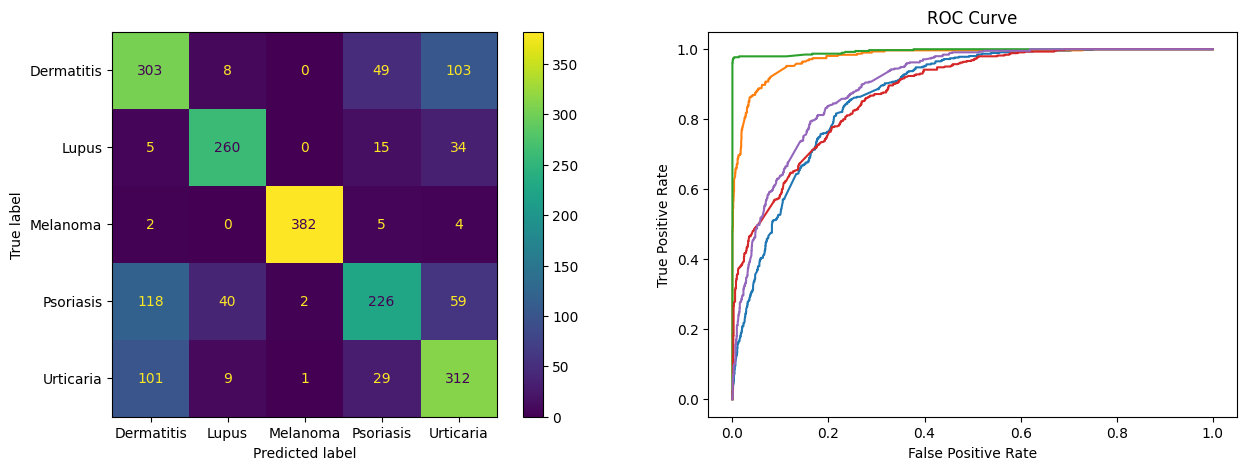

In [76]:
best_params = hyperopt_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

In [77]:
best_params = grid_search_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

KeyboardInterrupt: 

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_noproc)
model_lr(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_noproc)
model_lr(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [ ]:
name = "LR_withproc_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_proc)
model_lr(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_proc)
model_lr(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lamatization

In [ ]:
name = "LR_lem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_lem)
model_lr(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_lem)
model_lr(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### With stemming

In [ ]:
name = "LR_stem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_stem)
model_lr(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_stem)
model_lr(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/LR/{best_modeltype_lr}.pkl')
print(best_score_lr)

#### Naive Bayes

**Important Parameters:**
- Alpha
- Fit Prior
- Class Prior

In [88]:
best_score_nb = 0
best_modeltype_nb = ""
best_model = None

##### Random Search ####

In [86]:
def random_search_nb(X_train):
    param_grid = {
        'alpha': np.random.uniform(0.0, 2.0, 50),
        'fit_prior': [True, False],
        'class_prior': [None] + [np.random.dirichlet(np.ones(np.unique(y_train).shape[0])) for _ in range(50)]
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        clf = MultinomialNB(alpha=params['alpha'], fit_prior=params['fit_prior'], class_prior=params['class_prior'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return score

    num_iterations = 50
    for _ in range(num_iterations):
        params = {k: np.random.choice(v) if k != 'class_prior' else v[np.random.randint(len(v))] for k, v in param_grid.items()}
        score = evaluate_params(params)
        if score > best_score:
            best_score = score
            best_params = params
    
    print("Best hyperparameters:", best_params)
    return best_params


##### Run Model

In [87]:
def model_nb(best_param, X_train, X_test, model_type):

    global best_score_nb, best_modeltype_nb, best_model

    nb = MultinomialNB(alpha=best_param['alpha'], fit_prior=best_param['fit_prior'], class_prior=best_param['class_prior'])
    nb.fit(X_train, y_train)
    score = evaluate(nb, X_train, X_test, y_train, y_test)
    if score > best_score_nb:
        best_score_nb = score
        best_modeltype_nb = model_type
        best_model = nb

##### Without Preprocessing

In [89]:
name = "NB_withoutyproc_"

**BoW** 

Best hyperparameters: {'alpha': 1.2484891144652335, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7336
Specificity Score: 0.7336
Precision Score: 0.7408
F1 Score: 0.7301

Testing Results
Accuracy Score: 0.6821
Specificity Score: 0.6821
Precision Score: 0.6915
F1 Score: 0.6790

Loss
Log loss: 0.7606381640987248

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.56      0.70      0.62      1803
       Lupus       0.82      0.85      0.83      1355
    Melanoma       0.92      0.98      0.95      1677
   Psoriasis       0.74      0.49      0.59      1668
   Urticaria       0.69      0.69      0.69      1764

    accuracy                           0.73      8267
   macro avg       0.75      0.74      0.74      8267
weighted avg       0.74      0.73      0.73      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.51      0.65      0.57       463
    

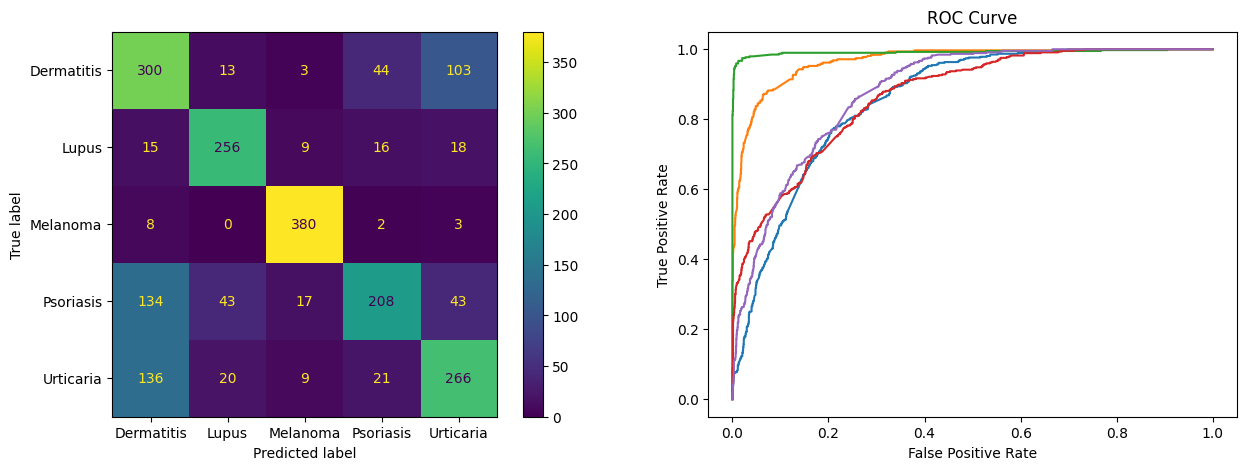

In [90]:
best_params = random_search_nb(X_train_bow_noproc)
model_nb(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.5473369371185599, 'fit_prior': True, 'class_prior': array([0.18678336, 0.28242882, 0.09909893, 0.24415149, 0.18753739])}
Training Results
Accuracy Score: 0.7642
Specificity Score: 0.7642
Precision Score: 0.7649
F1 Score: 0.7607

Testing Results
Accuracy Score: 0.6933
Specificity Score: 0.6933
Precision Score: 0.6932
F1 Score: 0.6884

Loss
Log loss: 0.8220741188413145

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.63      0.66      1803
       Lupus       0.69      0.93      0.79      1355
    Melanoma       0.97      0.98      0.98      1677
   Psoriasis       0.70      0.64      0.67      1668
   Urticaria       0.76      0.68      0.72      1764

    accuracy                           0.76      8267
   macro avg       0.76      0.77      0.76      8267
weighted avg       0.76      0.76      0.76      8267


Classification Report Test
              precision    recall  f1-score   supp

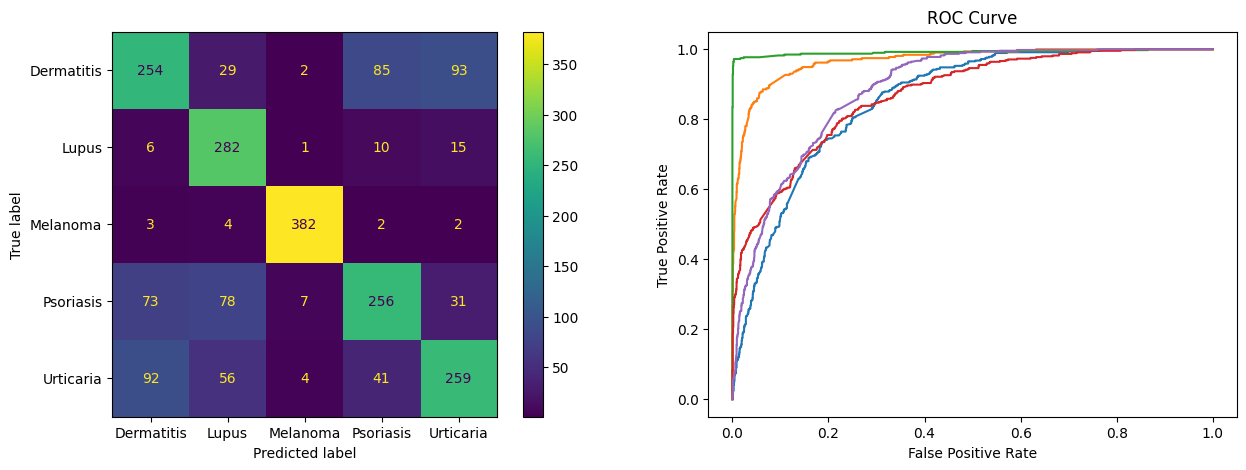

In [91]:
best_params = random_search_nb(X_train_ngram_noproc)
model_nb(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.7207350021969268, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.7451
Specificity Score: 0.7451
Precision Score: 0.7460
F1 Score: 0.7401

Testing Results
Accuracy Score: 0.7083
Specificity Score: 0.7083
Precision Score: 0.7079
F1 Score: 0.7031

Loss
Log loss: 0.9346418111239709

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.66      0.65      0.65      1803
       Lupus       0.87      0.79      0.83      1355
    Melanoma       0.81      0.98      0.89      1677
   Psoriasis       0.75      0.55      0.63      1668
   Urticaria       0.68      0.78      0.73      1764

    accuracy                           0.75      8267
   macro avg       0.75      0.75      0.74      8267
weighted avg       0.75      0.75      0.74      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.59      0.61      0.60       463
   

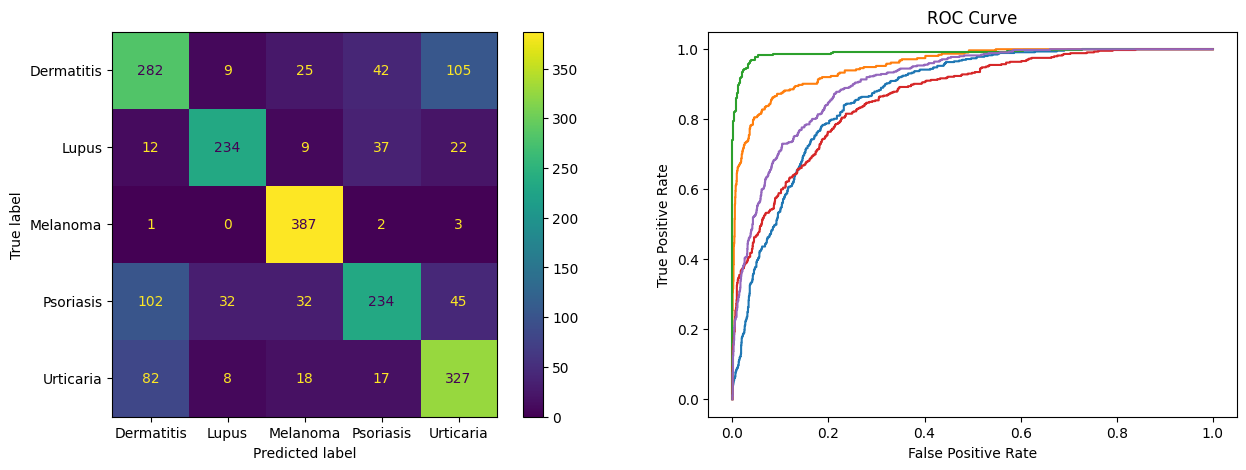

In [92]:
best_params = random_search_nb(X_train_tfidf_noproc)
model_nb(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 0.39525770054939624, 'fit_prior': True, 'class_prior': array([0.18254586, 0.26523034, 0.09171236, 0.28262705, 0.17788439])}
Training Results
Accuracy Score: 0.7936
Specificity Score: 0.7936
Precision Score: 0.8002
F1 Score: 0.7948

Testing Results
Accuracy Score: 0.7267
Specificity Score: 0.7267
Precision Score: 0.7344
F1 Score: 0.7283

Loss
Log loss: 0.7351122631865924

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.65      0.69      1803
       Lupus       0.89      0.82      0.85      1355
    Melanoma       0.99      0.94      0.96      1677
   Psoriasis       0.67      0.78      0.72      1668
   Urticaria       0.74      0.79      0.76      1764

    accuracy                           0.79      8267
   macro avg       0.81      0.80      0.80      8267
weighted avg       0.80      0.79      0.79      8267


Classification Report Test
              precision    recall  f1-score   sup

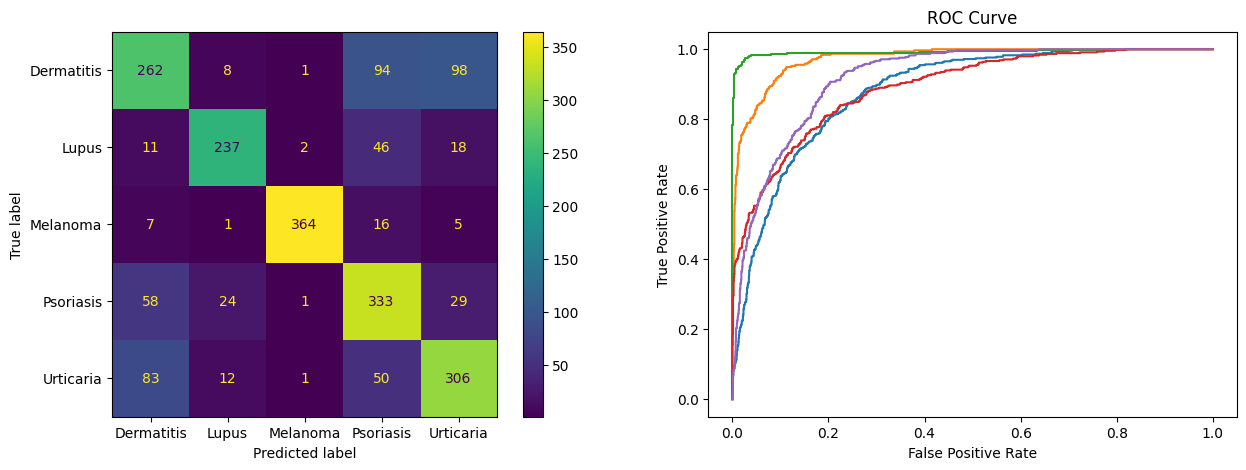

In [93]:
best_params = random_search_nb(X_train_tfidf_ngram_noproc)
model_nb(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [94]:
name = "NB_withproc_"

**BoW** 

Best hyperparameters: {'alpha': 1.0826648125705642, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7363
Specificity Score: 0.7363
Precision Score: 0.7367
F1 Score: 0.7328

Testing Results
Accuracy Score: 0.6875
Specificity Score: 0.6875
Precision Score: 0.6909
F1 Score: 0.6841

Loss
Log loss: 0.7664399212933765

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.59      0.67      0.63      1803
       Lupus       0.83      0.83      0.83      1355
    Melanoma       0.90      0.98      0.93      1677
   Psoriasis       0.71      0.53      0.61      1668
   Urticaria       0.69      0.70      0.69      1764

    accuracy                           0.74      8267
   macro avg       0.74      0.74      0.74      8267
weighted avg       0.74      0.74      0.73      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.52      0.64      0.58       463
    

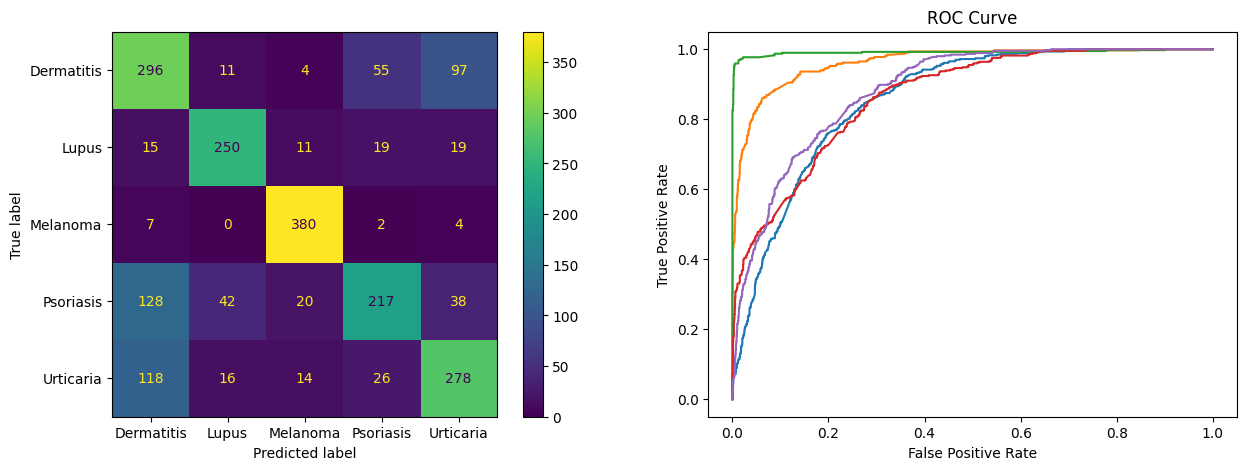

In [95]:
best_params = random_search_nb(X_train_bow_proc)
model_nb(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.1401038628265976, 'fit_prior': False, 'class_prior': array([0.14311834, 0.20523945, 0.00977691, 0.35310939, 0.28875591])}
Training Results
Accuracy Score: 0.7751
Specificity Score: 0.7751
Precision Score: 0.7927
F1 Score: 0.7702

Testing Results
Accuracy Score: 0.6889
Specificity Score: 0.6889
Precision Score: 0.6977
F1 Score: 0.6828

Loss
Log loss: 0.9199445192018744

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.82      0.47      0.59      1803
       Lupus       0.87      0.87      0.87      1355
    Melanoma       1.00      0.98      0.99      1677
   Psoriasis       0.62      0.80      0.70      1668
   Urticaria       0.68      0.80      0.74      1764

    accuracy                           0.78      8267
   macro avg       0.80      0.78      0.78      8267
weighted avg       0.79      0.78      0.77      8267


Classification Report Test
              precision    recall  f1-score   sup

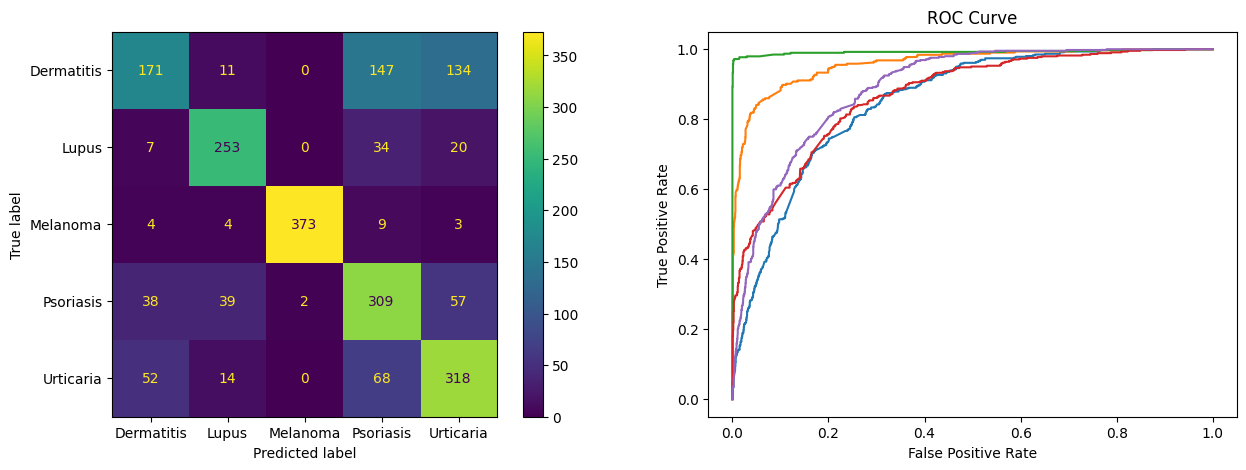

In [96]:
best_params = random_search_nb(X_train_ngram_proc)
model_nb(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 0.9629118842150988, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7483
Specificity Score: 0.7483
Precision Score: 0.7502
F1 Score: 0.7461

Testing Results
Accuracy Score: 0.7073
Specificity Score: 0.7073
Precision Score: 0.7122
F1 Score: 0.7055

Loss
Log loss: 0.7965957146051424

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.63      0.64      0.64      1803
       Lupus       0.85      0.80      0.82      1355
    Melanoma       0.90      0.98      0.94      1677
   Psoriasis       0.75      0.59      0.66      1668
   Urticaria       0.65      0.75      0.69      1764

    accuracy                           0.75      8267
   macro avg       0.76      0.75      0.75      8267
weighted avg       0.75      0.75      0.75      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.57      0.62      0.59       463
    

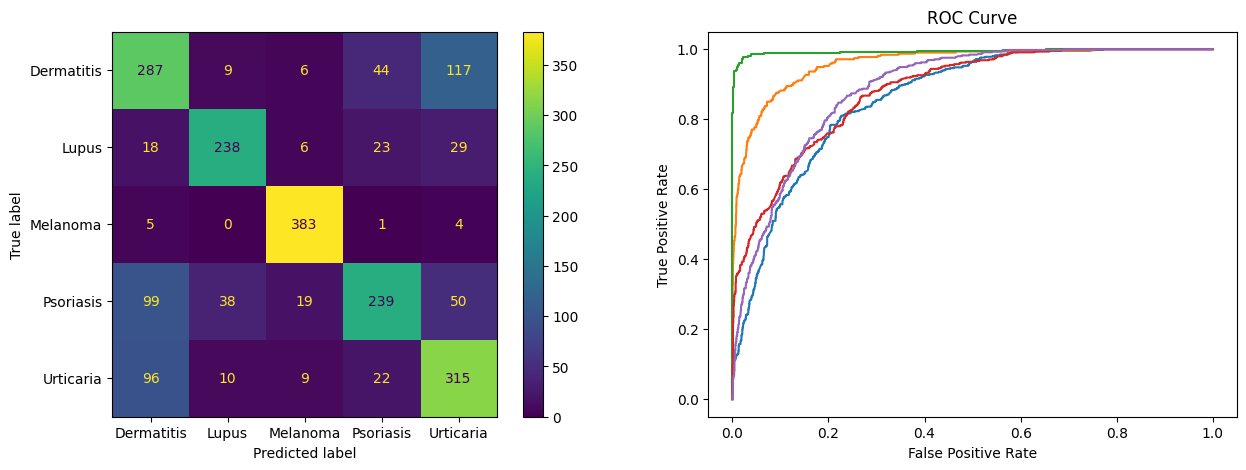

In [97]:
best_params = random_search_nb(X_train_tfidf_proc)
model_nb(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 1.1008429546687433, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.7958
Specificity Score: 0.7958
Precision Score: 0.7986
F1 Score: 0.7952

Testing Results
Accuracy Score: 0.7088
Specificity Score: 0.7088
Precision Score: 0.7117
F1 Score: 0.7074

Loss
Log loss: 0.7857084766091998

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.71      0.71      1803
       Lupus       0.87      0.85      0.86      1355
    Melanoma       0.95      0.99      0.97      1677
   Psoriasis       0.81      0.67      0.73      1668
   Urticaria       0.69      0.78      0.73      1764

    accuracy                           0.80      8267
   macro avg       0.80      0.80      0.80      8267
weighted avg       0.80      0.80      0.80      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.56      0.60      0.58       463
   

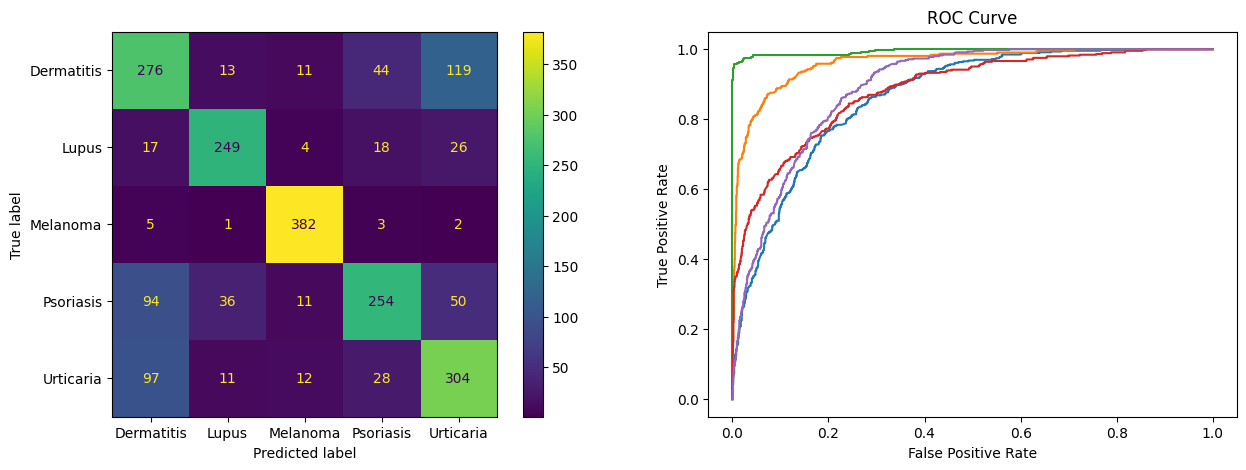

In [98]:
best_params = random_search_nb(X_train_tfidf_ngram_proc)
model_nb(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lematization

In [99]:
name = "NB_lem_"

**BoW** 

Best hyperparameters: {'alpha': 0.4061503028694211, 'fit_prior': False, 'class_prior': array([0.17285327, 0.3275976 , 0.07177227, 0.22490236, 0.2028745 ])}
Training Results
Accuracy Score: 0.8205
Specificity Score: 0.8205
Precision Score: 0.8195
F1 Score: 0.8185

Testing Results
Accuracy Score: 0.7905
Specificity Score: 0.7905
Precision Score: 0.7912
F1 Score: 0.7885

Loss
Log loss: 0.5559921450229458

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.69      0.71      1803
       Lupus       0.80      0.94      0.87      1355
    Melanoma       0.96      0.94      0.95      1677
   Psoriasis       0.77      0.71      0.73      1668
   Urticaria       0.82      0.86      0.84      1764

    accuracy                           0.82      8267
   macro avg       0.82      0.83      0.82      8267
weighted avg       0.82      0.82      0.82      8267


Classification Report Test
              precision    recall  f1-score   sup

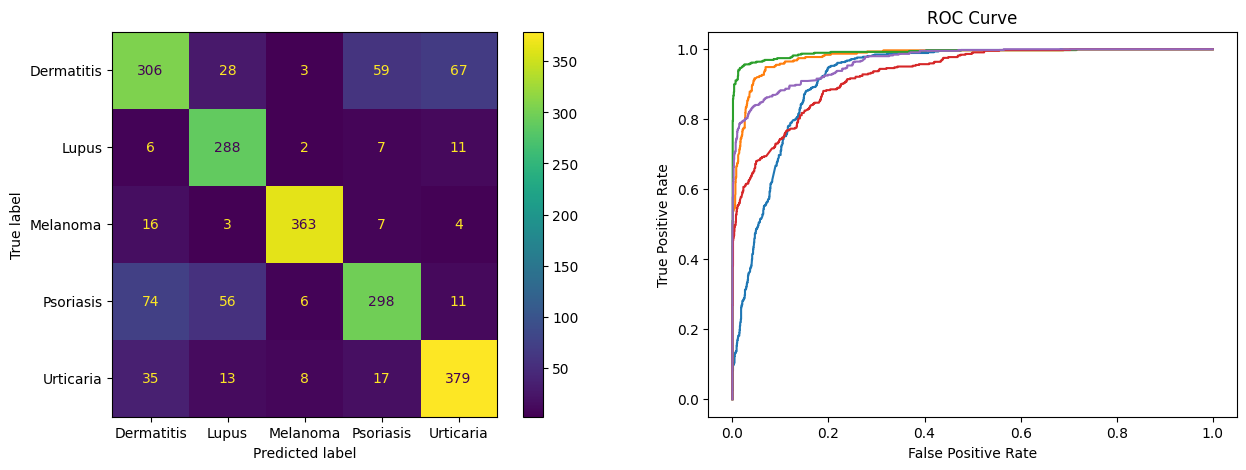

In [100]:
best_params = random_search_nb(X_train_bow_lem)
model_nb(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.20974872131775313, 'fit_prior': False, 'class_prior': array([0.29294254, 0.28368017, 0.08005582, 0.1947867 , 0.14853476])}
Training Results
Accuracy Score: 0.8680
Specificity Score: 0.8680
Precision Score: 0.8733
F1 Score: 0.8681

Testing Results
Accuracy Score: 0.8065
Specificity Score: 0.8065
Precision Score: 0.8117
F1 Score: 0.8062

Loss
Log loss: 0.6671951668338469

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.86      0.79      1803
       Lupus       0.88      0.94      0.91      1355
    Melanoma       0.98      0.97      0.98      1677
   Psoriasis       0.88      0.73      0.80      1668
   Urticaria       0.89      0.86      0.87      1764

    accuracy                           0.87      8267
   macro avg       0.88      0.87      0.87      8267
weighted avg       0.87      0.87      0.87      8267


Classification Report Test
              precision    recall  f1-score   su

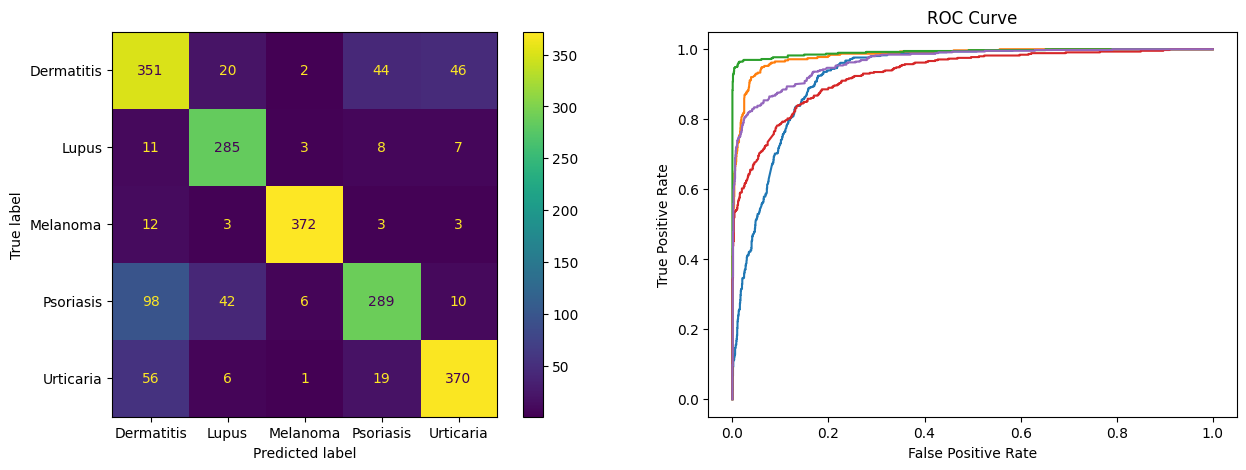

In [101]:
best_params = random_search_nb(X_train_ngram_lem)
model_nb(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.9875643160935246, 'fit_prior': False, 'class_prior': array([0.25453472, 0.09900027, 0.23750063, 0.23876924, 0.17019514])}
Training Results
Accuracy Score: 0.8048
Specificity Score: 0.8048
Precision Score: 0.8181
F1 Score: 0.8052

Testing Results
Accuracy Score: 0.7731
Specificity Score: 0.7731
Precision Score: 0.7870
F1 Score: 0.7729

Loss
Log loss: 0.6689117547055577

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.68      0.82      0.74      1803
       Lupus       0.96      0.68      0.80      1355
    Melanoma       0.87      0.97      0.92      1677
   Psoriasis       0.73      0.72      0.73      1668
   Urticaria       0.89      0.80      0.84      1764

    accuracy                           0.80      8267
   macro avg       0.82      0.80      0.81      8267
weighted avg       0.82      0.80      0.81      8267


Classification Report Test
              precision    recall  f1-score   sup

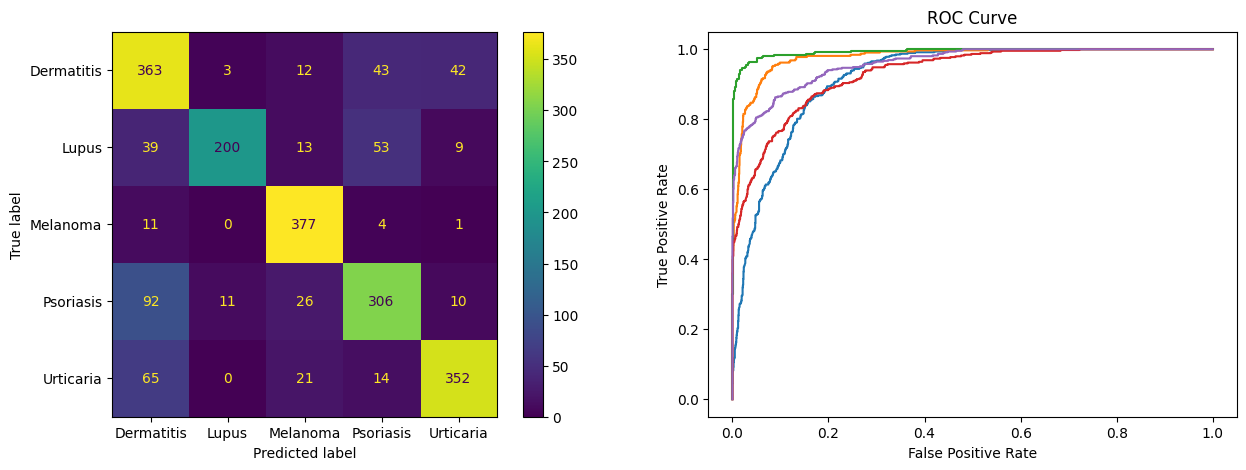

In [102]:
best_params = random_search_nb(X_train_tfidf_lem)
model_nb(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 0.8755201593986777, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.8696
Specificity Score: 0.8696
Precision Score: 0.8726
F1 Score: 0.8696

Testing Results
Accuracy Score: 0.8070
Specificity Score: 0.8070
Precision Score: 0.8104
F1 Score: 0.8063

Loss
Log loss: 0.5737480092449891

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.78      0.81      0.80      1803
       Lupus       0.95      0.88      0.91      1355
    Melanoma       0.96      0.98      0.97      1677
   Psoriasis       0.88      0.77      0.82      1668
   Urticaria       0.82      0.91      0.86      1764

    accuracy                           0.87      8267
   macro avg       0.88      0.87      0.87      8267
weighted avg       0.87      0.87      0.87      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.70      0.73      0.71       463
    

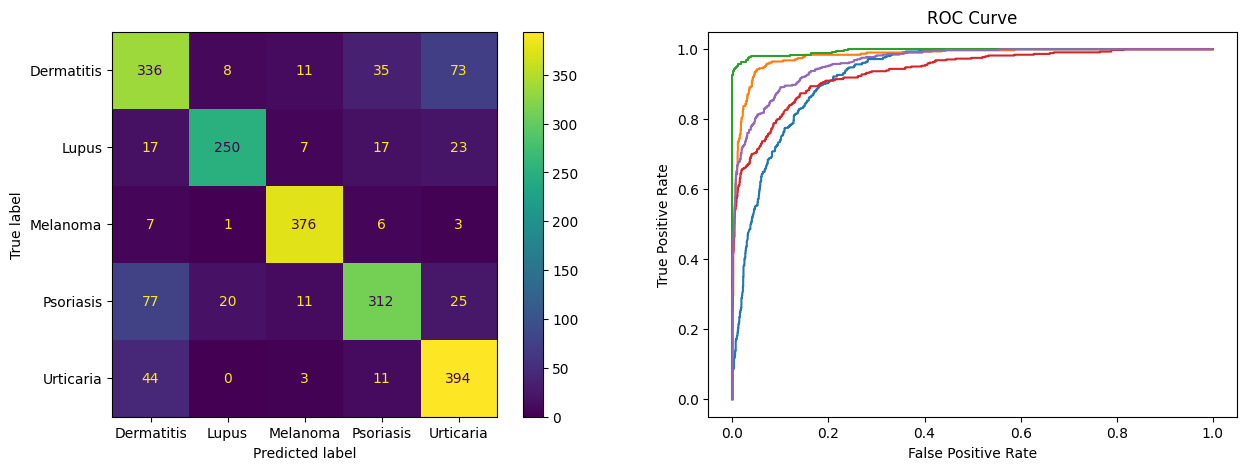

In [103]:
best_params = random_search_nb(X_train_tfidf_ngram_lem)
model_nb(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### Witth stemming

In [104]:
name = "NB_stem_"

**BoW** 

Best hyperparameters: {'alpha': 0.3939649357392121, 'fit_prior': False, 'class_prior': array([0.21185651, 0.34578982, 0.07557599, 0.22136404, 0.14541364])}
Training Results
Accuracy Score: 0.8651
Specificity Score: 0.8651
Precision Score: 0.8643
F1 Score: 0.8638

Testing Results
Accuracy Score: 0.8292
Specificity Score: 0.8292
Precision Score: 0.8285
F1 Score: 0.8274

Loss
Log loss: 0.508504451523028

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.81      0.75      0.78      1803
       Lupus       0.88      0.97      0.92      1355
    Melanoma       0.98      0.96      0.97      1677
   Psoriasis       0.82      0.77      0.80      1668
   Urticaria       0.84      0.90      0.87      1764

    accuracy                           0.87      8267
   macro avg       0.87      0.87      0.87      8267
weighted avg       0.86      0.87      0.86      8267


Classification Report Test
              precision    recall  f1-score   supp

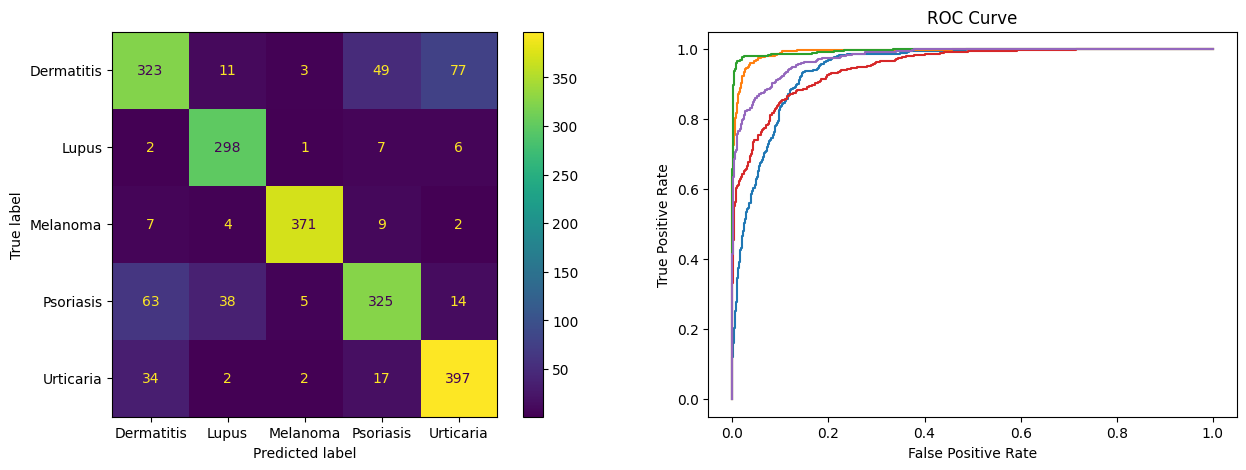

In [105]:
best_params = random_search_nb(X_train_bow_stem)
model_nb(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.29084171285483107, 'fit_prior': False, 'class_prior': array([0.58093784, 0.00970391, 0.13955305, 0.17192629, 0.09787891])}
Training Results
Accuracy Score: 0.9711
Specificity Score: 0.9711
Precision Score: 0.9715
F1 Score: 0.9711

Testing Results
Accuracy Score: 0.8645
Specificity Score: 0.8645
Precision Score: 0.8689
F1 Score: 0.8653

Loss
Log loss: 0.9515677908390288

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.94      0.97      0.95      1803
       Lupus       0.99      0.99      0.99      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.98      0.93      0.96      1668
   Urticaria       0.96      0.98      0.97      1764

    accuracy                           0.97      8267
   macro avg       0.97      0.97      0.97      8267
weighted avg       0.97      0.97      0.97      8267


Classification Report Test
              precision    recall  f1-score   su

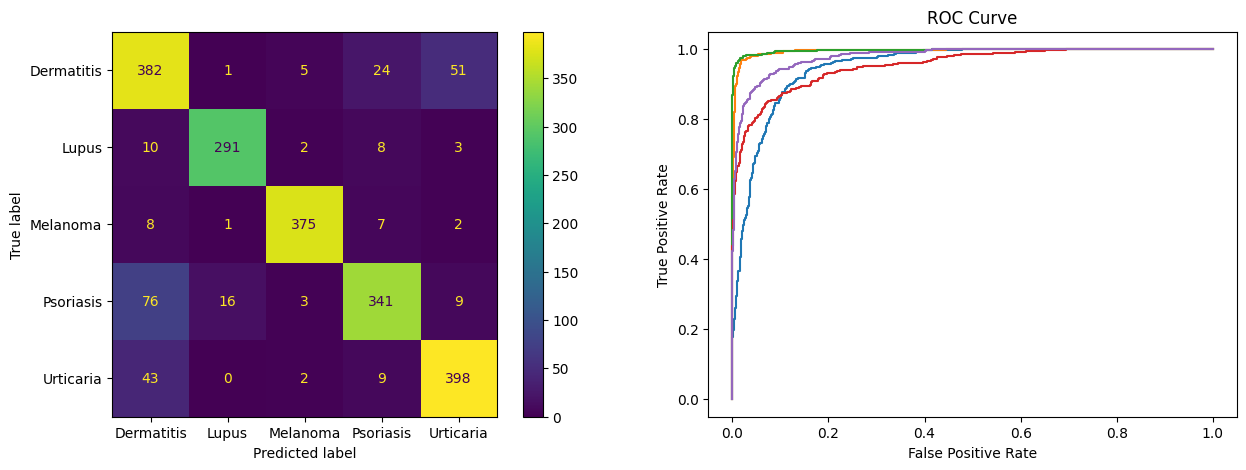

In [106]:
best_params = random_search_nb(X_train_ngram_stem)
model_nb(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.5654076533714316, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.8473
Specificity Score: 0.8473
Precision Score: 0.8478
F1 Score: 0.8442

Testing Results
Accuracy Score: 0.8133
Specificity Score: 0.8133
Precision Score: 0.8135
F1 Score: 0.8092

Loss
Log loss: 0.5856937775578586

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.83      0.68      0.74      1803
       Lupus       0.89      0.94      0.91      1355
    Melanoma       0.93      0.97      0.95      1677
   Psoriasis       0.83      0.76      0.79      1668
   Urticaria       0.78      0.91      0.84      1764

    accuracy                           0.85      8267
   macro avg       0.85      0.85      0.85      8267
weighted avg       0.85      0.85      0.84      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.77      0.62      0.69       463
   

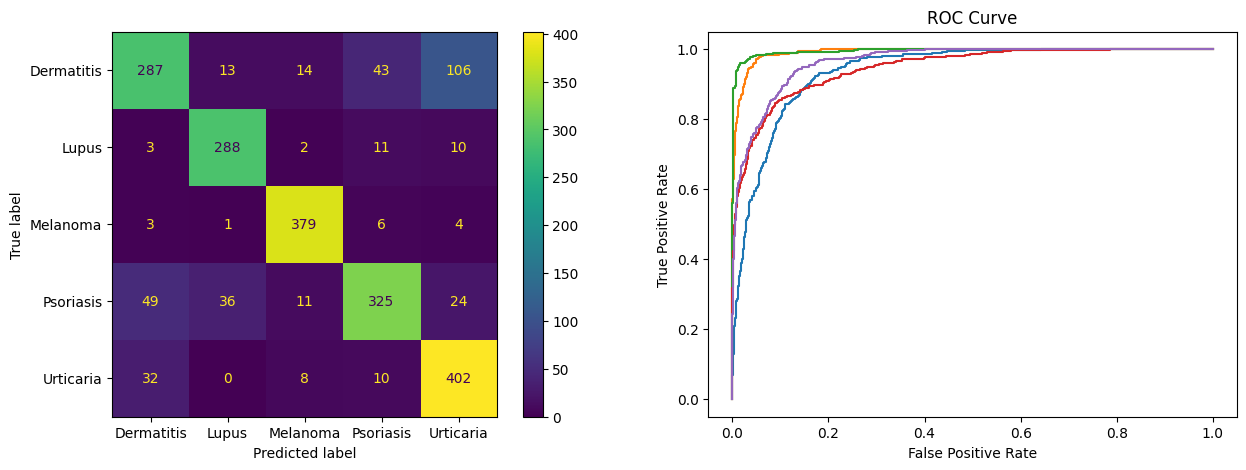

In [107]:
best_params = random_search_nb(X_train_tfidf_stem)
model_nb(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 0.17060597653111054, 'fit_prior': False, 'class_prior': array([0.33782388, 0.13216436, 0.24754759, 0.1741489 , 0.10831527])}
Training Results
Accuracy Score: 0.9754
Specificity Score: 0.9754
Precision Score: 0.9764
F1 Score: 0.9755

Testing Results
Accuracy Score: 0.8539
Specificity Score: 0.8539
Precision Score: 0.8701
F1 Score: 0.8558

Loss
Log loss: 0.43825443117891416

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.93      0.99      0.96      1803
       Lupus       0.99      1.00      0.99      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      0.93      0.96      1668
   Urticaria       0.98      0.97      0.97      1764

    accuracy                           0.98      8267
   macro avg       0.98      0.98      0.98      8267
weighted avg       0.98      0.98      0.98      8267


Classification Report Test
              precision    recall  f1-score   s

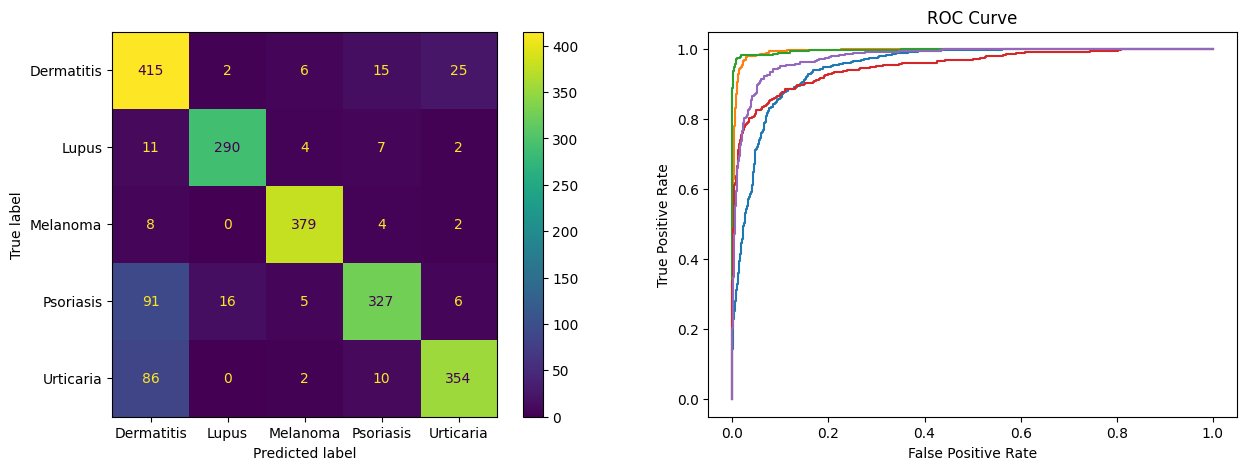

In [108]:
best_params = random_search_nb(X_train_tfidf_ngram_stem)
model_nb(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [109]:
joblib.dump(best_model,f'Models/NB/{best_modeltype_nb}.pkl')
print(best_score_nb)

0.865286965596209


#### Support Vector Machinne

**Important Parameters:**
- Kernel
- Gamma
- C

In [43]:
best_score_svm = 0
best_modeltype_svm = ""
best_model = None

In [44]:
def train_and_evaluate(params, X_train, y_train):
    clf = SVC(**params)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

##### Random Search #####

In [45]:
def random_search_svm(X_train):
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear']
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        score = train_and_evaluate(params, X_train, y_train)
        return score

    num_iterations = 50
    num_jobs = 4  # Número de trabalhos em paralelo
    results = Parallel(n_jobs=num_jobs)(delayed(evaluate_params)({k: np.random.choice(v) for k, v in param_grid.items()}) for _ in range(num_iterations))
    
    best_index = np.argmax(results)
    best_params = {k: np.random.choice(v) for k, v in param_grid.items()}
    best_score = results[best_index]
    
    print("Best hyperparameters:", best_params)
    return best_params

##### Run Model

In [46]:
def model_svm(best_param, X_train, X_test, model_type):

    global best_score_svm, best_modeltype_svm, best_model

    svm = SVC(probability=True,C=best_param['C'], gamma = best_param['gamma'], kernel=best_param['kernel'])
    svm.fit(X_train, y_train)
    score = evaluate(svm, X_train, X_test, y_train, y_test)
    if score > best_score_svm:
        best_score_svm = score
        best_modeltype_svm = model_type
        best_model = svm

##### Without Preprocessing

In [47]:
name = "SVM_withoutyproc_"

**BoW** 

In [48]:
best_params = random_search_svm(X_train_bow_noproc)
model_svm(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

KeyboardInterrupt: 

**BoW n-grams**

In [25]:
best_params = random_search_svm(X_train_ngram_noproc)
model_svm(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

KeyboardInterrupt: 

**TF-IDF**

Best hyperparameters: {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8121
Specificity Score: 0.8121
Precision Score: 0.8178
F1 Score: 0.8120

Testing Results
Accuracy Score: 0.7586
Specificity Score: 0.7586
Precision Score: 0.7704
F1 Score: 0.7595

Loss
Log loss: 0.5953231241849365

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.67      0.78      0.72      1803
       Lupus       0.90      0.87      0.88      1355
    Melanoma       1.00      0.98      0.99      1677
   Psoriasis       0.79      0.63      0.70      1668
   Urticaria       0.76      0.81      0.79      1764

    accuracy                           0.81      8267
   macro avg       0.82      0.81      0.82      8267
weighted avg       0.82      0.81      0.81      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.59      0.74      0.66       463
       Lupus       0.86   

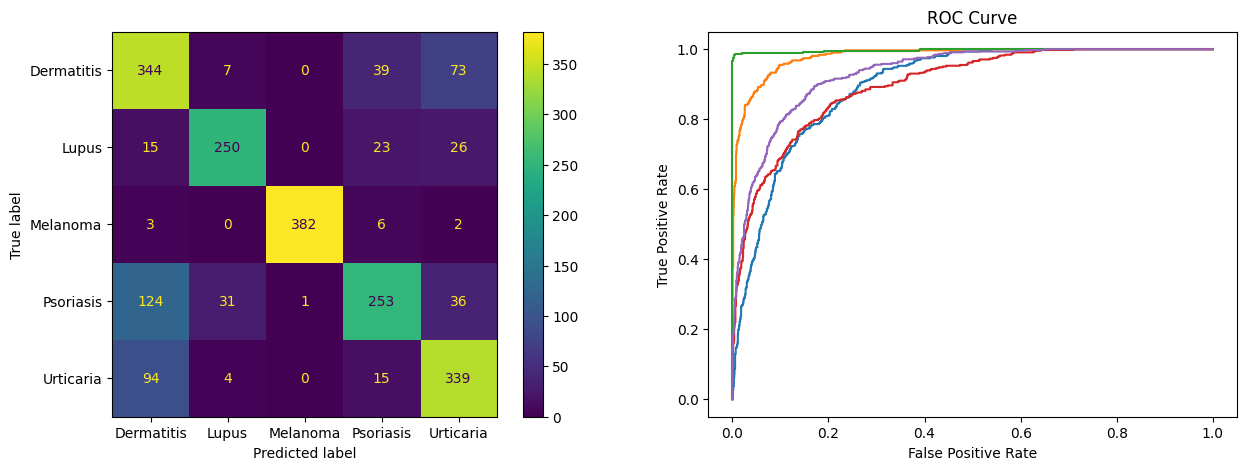

In [ ]:
best_params = random_search_svm(X_train_tfidf_noproc)
model_svm(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_svm(X_train_tfidf_ngram_noproc)
model_svm(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [25]:
name = "SVM_withproc_"

**BoW** 

Best hyperparameters: {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.5177
Specificity Score: 0.5177
Precision Score: 0.5811
F1 Score: 0.5003

Testing Results
Accuracy Score: 0.5017
Specificity Score: 0.5017
Precision Score: 0.5446
F1 Score: 0.4794

Loss
Log loss: 0.9953317831068764

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.41      0.68      0.51      1803
       Lupus       0.77      0.45      0.57      1355
    Melanoma       1.00      0.68      0.81      1677
   Psoriasis       0.39      0.08      0.13      1668
   Urticaria       0.39      0.67      0.50      1764

    accuracy                           0.52      8267
   macro avg       0.59      0.51      0.50      8267
weighted avg       0.58      0.52      0.50      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.39      0.66      0.49       463
       Lupus       0.73      0

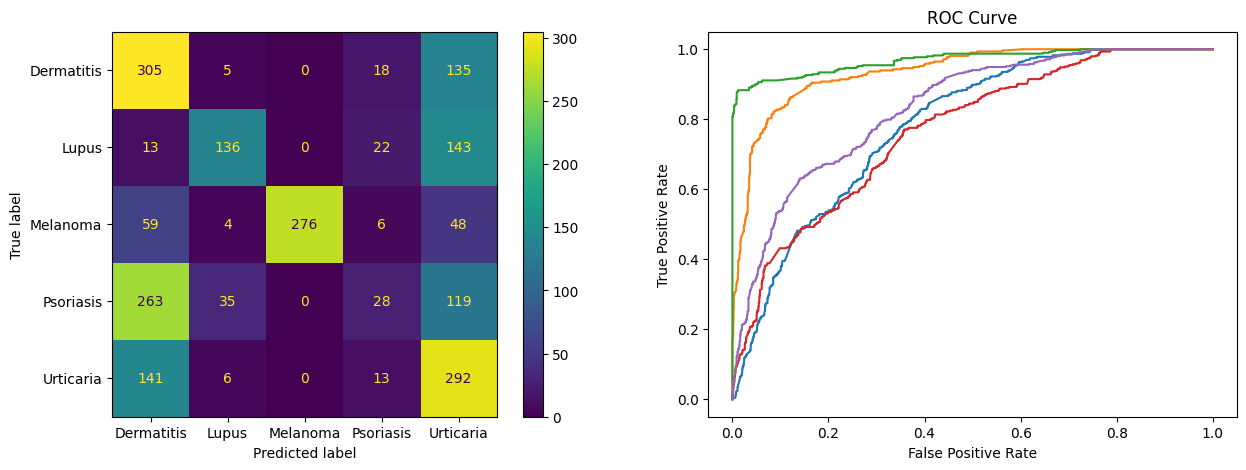

In [26]:
best_params = random_search_svm(X_train_bow_proc)
model_svm(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 1.0, 'gamma': 1.0, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.2603
Specificity Score: 0.2603
Precision Score: 0.8108
F1 Score: 0.1617

Testing Results
Accuracy Score: 0.2453
Specificity Score: 0.2453
Precision Score: 0.7908
F1 Score: 0.1248

Loss
Log loss: 1.5768711037836953

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      0.99      0.37      1803
       Lupus       1.00      0.10      0.18      1355
    Melanoma       1.00      0.06      0.11      1677
   Psoriasis       1.00      0.01      0.03      1668
   Urticaria       0.90      0.06      0.11      1764

    accuracy                           0.26      8267
   macro avg       0.83      0.24      0.16      8267
weighted avg       0.81      0.26      0.16      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.23      1.00      0.37       463
       Lupus       1.00      

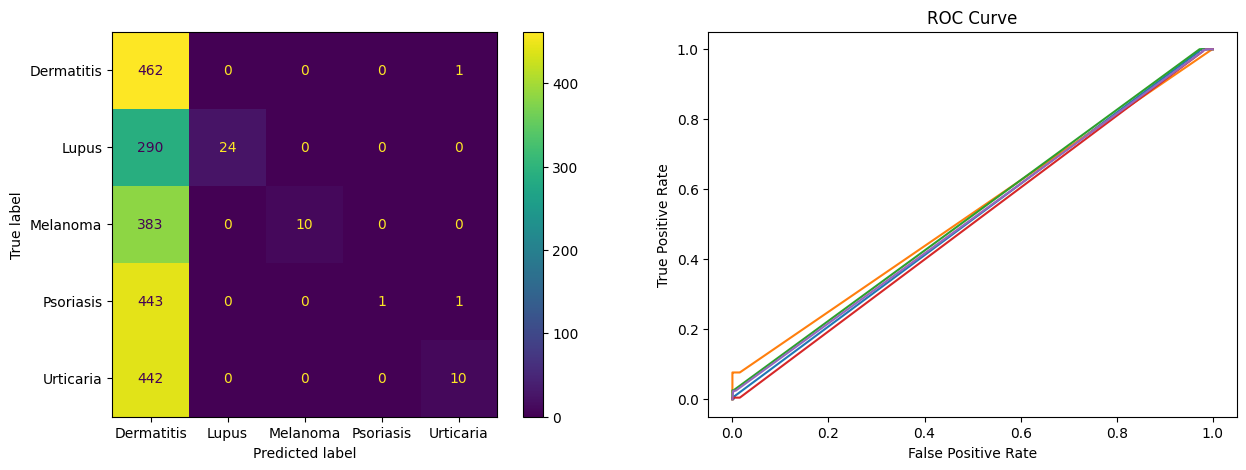

In [27]:
best_params = random_search_svm(X_train_ngram_proc)
model_svm(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.9265
Specificity Score: 0.9265
Precision Score: 0.9269
F1 Score: 0.9265

Testing Results
Accuracy Score: 0.7291
Specificity Score: 0.7291
Precision Score: 0.7319
F1 Score: 0.7298

Loss
Log loss: 0.6881017255613924

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.87      0.90      0.88      1803
       Lupus       0.97      0.97      0.97      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       0.91      0.87      0.89      1668
   Urticaria       0.90      0.91      0.90      1764

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.65      0.62       463
       Lupus       0.81      0.

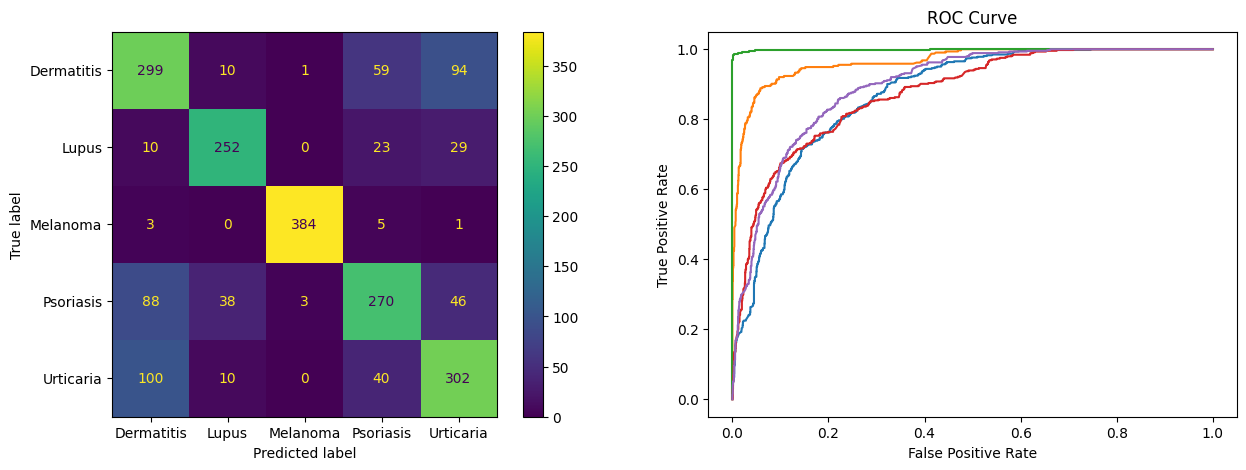

In [28]:
best_params = random_search_svm(X_train_tfidf_proc)
model_svm(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_svm(X_train_tfidf_ngram_proc)
model_svm(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lamatization

In [29]:
name = "SVM_lem_"

**BoW** 

Best hyperparameters: {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.6762
Specificity Score: 0.6762
Precision Score: 0.7628
F1 Score: 0.6773

Testing Results
Accuracy Score: 0.5883
Specificity Score: 0.5883
Precision Score: 0.7014
F1 Score: 0.5913

Loss
Log loss: 0.7797504971961586

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.63      0.66      1803
       Lupus       0.92      0.35      0.51      1355
    Melanoma       1.00      0.66      0.80      1677
   Psoriasis       0.78      0.78      0.78      1668
   Urticaria       0.47      0.89      0.62      1764

    accuracy                           0.68      8267
   macro avg       0.77      0.66      0.67      8267
weighted avg       0.76      0.68      0.68      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.62      0.51      0.56       463
       Lupus       0.89      0.3

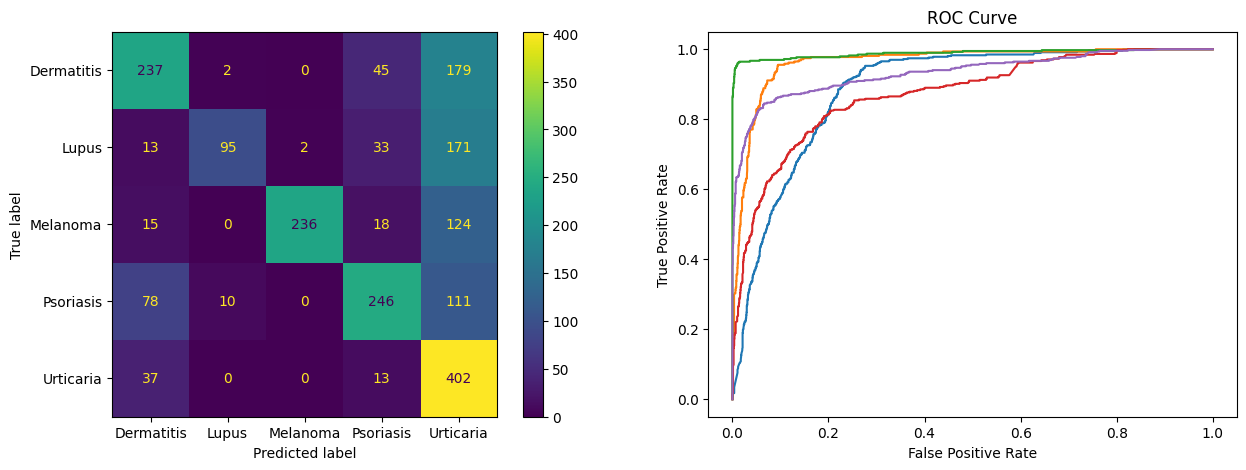

In [30]:
best_params = random_search_svm(X_train_bow_lem)
model_svm(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2307
Specificity Score: 0.2307
Precision Score: 0.2121
F1 Score: 0.1023

Testing Results
Accuracy Score: 0.2342
Specificity Score: 0.2342
Precision Score: 0.2026
F1 Score: 0.1017

Loss
Log loss: 1.5208643069098096

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       1.00      0.08      0.14      1355
    Melanoma       0.00      0.00      0.00      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.23      8267
   macro avg       0.24      0.22      0.10      8267
weighted avg       0.21      0.23      0.10      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.23      1.00      0.37       463
       Lupus       1.00      

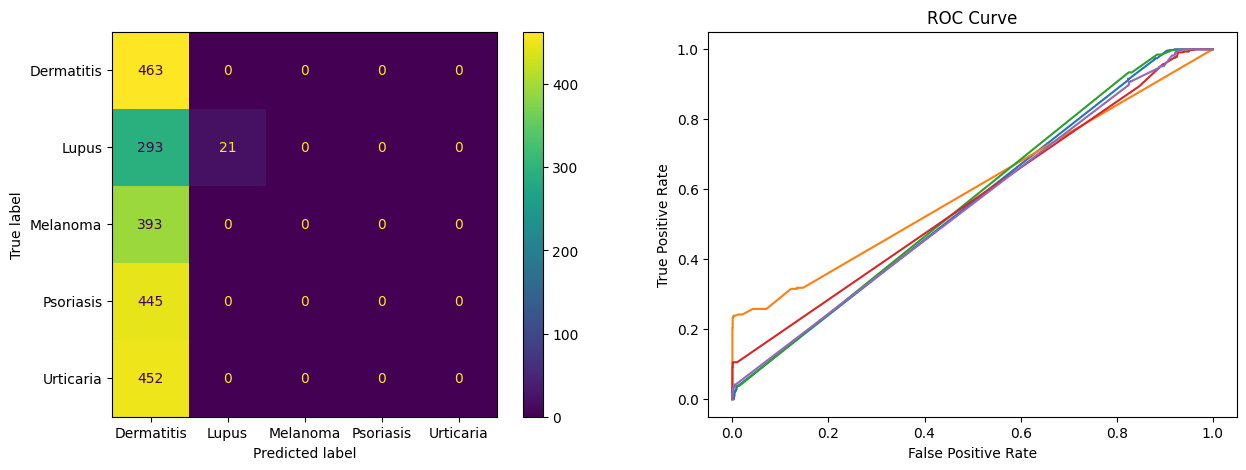

In [31]:
best_params = random_search_svm(X_train_ngram_lem)
model_svm(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2181
Specificity Score: 0.2181
Precision Score: 0.0476
F1 Score: 0.0781

Testing Results
Accuracy Score: 0.2240
Specificity Score: 0.2240
Precision Score: 0.0502
F1 Score: 0.0820

Loss
Log loss: 0.8622672506698519

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.00      0.00      0.00      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.04      0.20      0.07      8267
weighted avg       0.05      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      

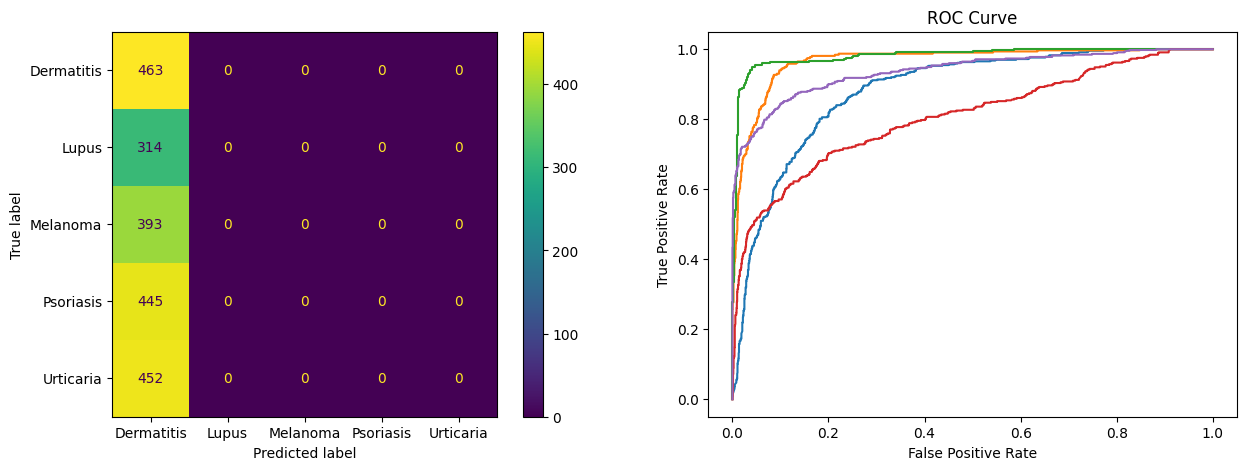

In [32]:
best_params = random_search_svm(X_train_tfidf_lem)
model_svm(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_svm(X_train_tfidf_ngram_lem)
model_svm(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### Witth stemming

In [33]:
name = "SVM_stem_"

**BoW** 

Best hyperparameters: {'C': 1.0, 'gamma': 0.1, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.9404
Specificity Score: 0.9404
Precision Score: 0.9426
F1 Score: 0.9407

Testing Results
Accuracy Score: 0.8723
Specificity Score: 0.8723
Precision Score: 0.8785
F1 Score: 0.8732

Loss
Log loss: 0.33983650659508624

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.85      0.94      0.89      1803
       Lupus       0.98      0.98      0.98      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.94      0.87      0.91      1668
   Urticaria       0.97      0.92      0.94      1764

    accuracy                           0.94      8267
   macro avg       0.95      0.94      0.94      8267
weighted avg       0.94      0.94      0.94      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.74      0.88      0.80       463
       Lupus       0.95     

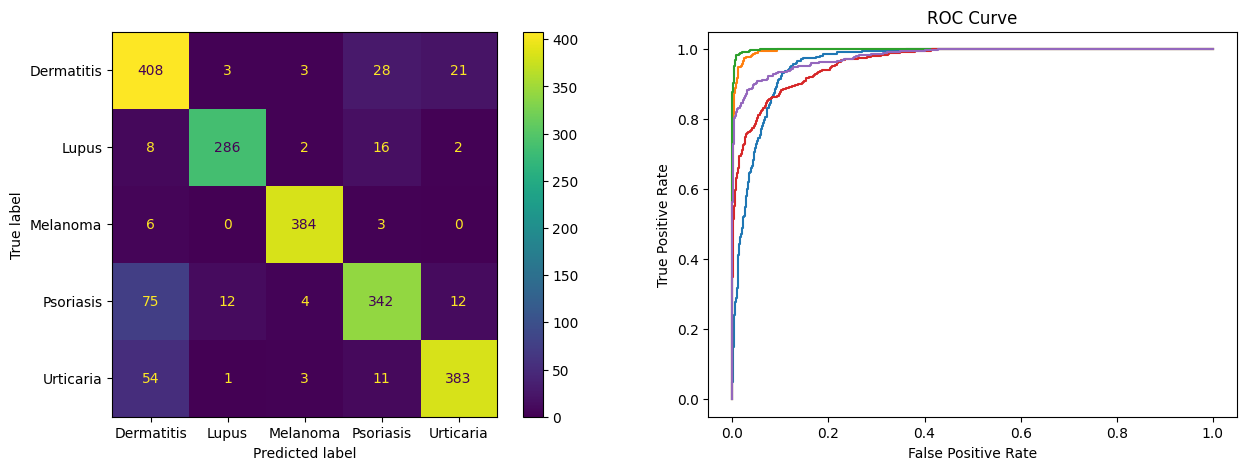

In [34]:
best_params = random_search_svm(X_train_bow_stem)
model_svm(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.9960
Specificity Score: 0.9960
Precision Score: 0.9961
F1 Score: 0.9960

Testing Results
Accuracy Score: 0.5530
Specificity Score: 0.5530
Precision Score: 0.7467
F1 Score: 0.5759

Loss
Log loss: 1.0447898764381747

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.98      1.00      0.99      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      0.99      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.33      0.86      0.47       463
       Lupus       0.95    

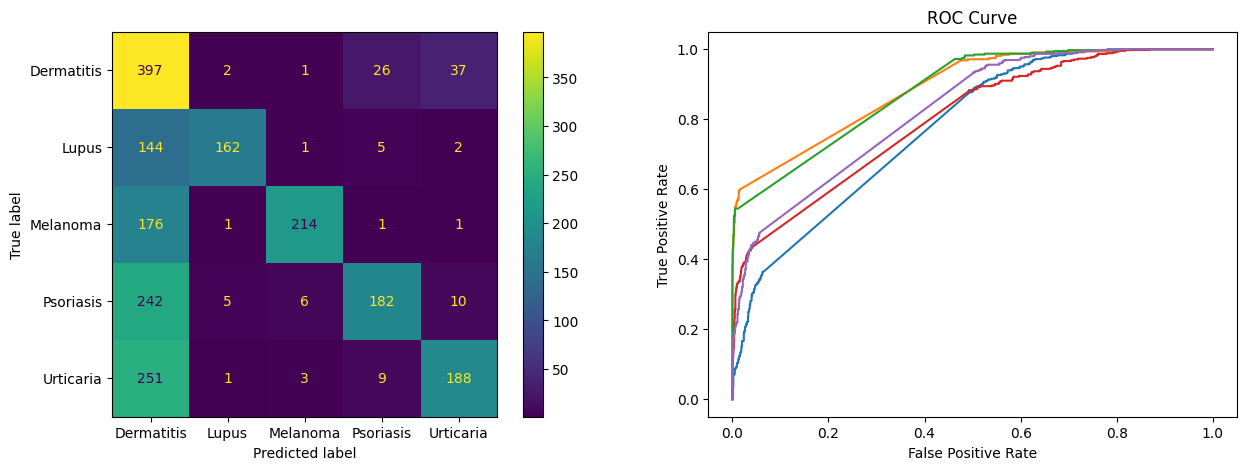

In [35]:
best_params = random_search_svm(X_train_ngram_stem)
model_svm(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.9803
Specificity Score: 0.9803
Precision Score: 0.9805
F1 Score: 0.9803

Testing Results
Accuracy Score: 0.8258
Specificity Score: 0.8258
Precision Score: 0.8333
F1 Score: 0.8275

Loss
Log loss: 0.44735921052718824

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.94      0.97      0.96      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       0.98      0.96      0.97      1668
   Urticaria       0.99      0.98      0.98      1764

    accuracy                           0.98      8267
   macro avg       0.98      0.98      0.98      8267
weighted avg       0.98      0.98      0.98      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.67      0.81      0.73       463
       Lupus       0.92

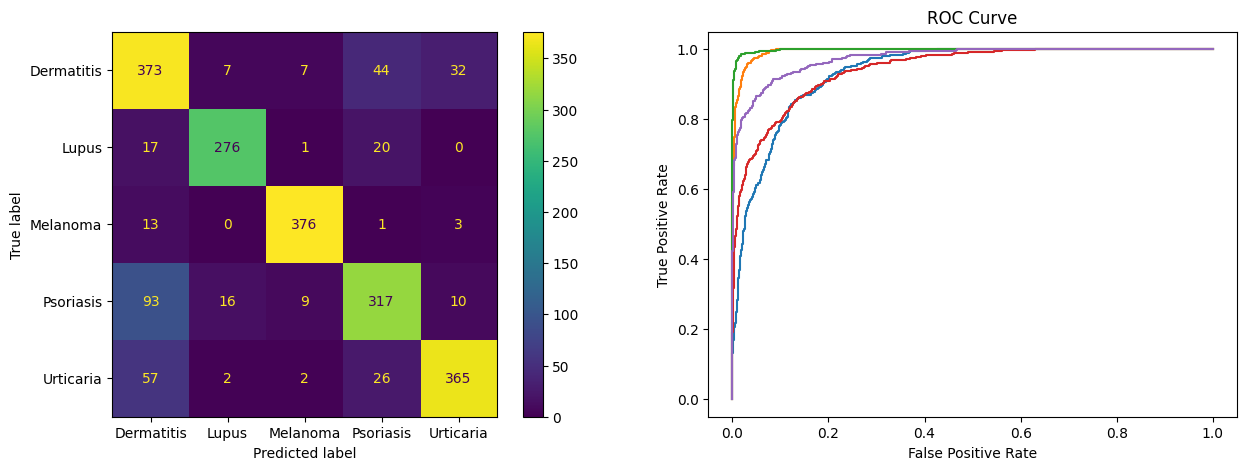

In [36]:
best_params = random_search_svm(X_train_tfidf_stem)
model_svm(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = random_search_svm(X_train_tfidf_ngram_stem)
model_svm(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [37]:
joblib.dump(best_model,f'Models/SVM/{best_modeltype_svm}.pkl')
print(best_score_svm)

0.8731900833795674


### Deep Learning

In [98]:
def preprocessing_dl(tokenizer, vocab_size, mean_length, X_train, X_test):
    #tokenizer = Tokenizer(num_words=vocab_size,oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Convert texts to sequences
    seq_train = tokenizer.texts_to_sequences(X_train)
    seq_test = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to the same size
    pad_train = pad_sequences(seq_train, maxlen = mean_length)
    pad_test = pad_sequences(seq_test, maxlen = mean_length)

    word_index = tokenizer.word_index
    print(len(word_index))
    return pad_train, pad_test


In [99]:
# Convert labels into numeric
diseases = {
    'Dermatitis': 0,
    'Lupus': 1,
    'Melanoma': 2,
    'Psoriasis': 3,
    'Urticaria': 4
}

# Create array with numeric diseases
train_labels = np.array(
    [diseases[label] for label in train['Disease']])
test_labels = np.array(
    [diseases[label] for label in test['Disease']])


In [100]:
def analyse_data(data):
    words = set()

    for sentence in data:
        for word in sentence:
            words.add(word)

    num_unique_words = len(words)
    print(f"Number of unique words: {num_unique_words}")

    mean_length = int(data.apply(' '.join).str.len().mean())
    print(f"Mean length: {mean_length}")

    return num_unique_words, mean_length

#### Recurrent Neural Network

##### Model

In [68]:
def RNN_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    rnn = Sequential(name="Basic_RNN")
    rnn.add(Embedding(vocab_size, embedding_dim))
    #rnn.add(SimpleRNN(128, activation='tanh', return_sequences= True))
    #rnn.add(SimpleRNN(64, activation='tanh', return_sequences = False))
    #rnn.add(Dense(32, activation='relu'))
    #rnn.add(Dense(5, activation='softmax'))
    rnn.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
    rnn.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
    rnn.add(SimpleRNN(32, activation='tanh'))
    rnn.add(Dropout(0.2))
    rnn.add(Dense(5, activation='softmax'))

    rnn.build(input_shape=(None, pad_train.shape[1]))

    print(rnn.summary())

    rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = rnn.fit(
        pad_train, 
        train_labels, 
        epochs=15,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(rnn, history, pad_test, test_labels)
    rnn.save('Models/RNN/rnn_'+ proc_type + '.pkl')

##### Without Preprocessing

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 4631
Mean length: 90
4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 90, 60)         │       277,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 90, 128)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 90, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_42 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,881 (1.24 MB)

 Trainable params: 323,881 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.2655 - loss: 1.6244 - val_accuracy: 0.4664 - val_loss: 1.2924
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.5318 - loss: 1.1751 - val_accuracy: 0.5602 - val_loss: 1.1063
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.6781 - loss: 0.8554 - val_accuracy: 0.7354 - val_loss: 0.6697
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.8104 - loss: 0.5198 - val_accuracy: 0.7586 - val_loss: 0.6481
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8772 - loss: 0.3606 - val_accuracy: 0.7712 - val_loss: 0.6076
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9013 - loss: 0.2932 - val_accuracy: 0.8016 - val_loss: 0.5907
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9152 - loss: 0.2353 - val_accuracy: 0.8128 - val_loss: 0.5631
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9312 - loss: 0.20

Loss:  0.6461209654808044
Accuracy:  0.8272859454154968


ValueError: Unable to synchronously create dataset (name already exists)

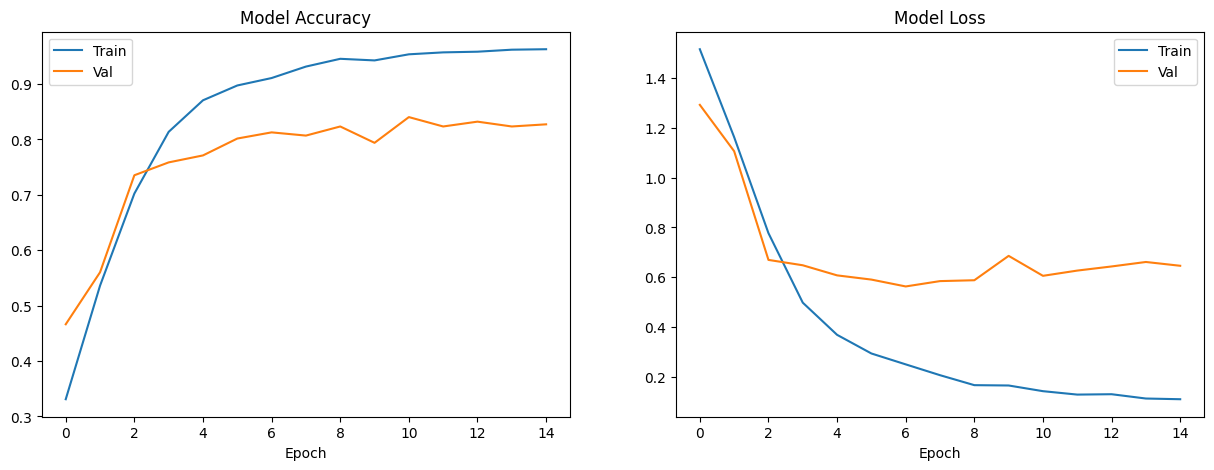

In [70]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input'], test['User_input'])

RNN_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2970
Mean length: 62
2731


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 62, 60)         │       178,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 62, 128)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 62, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_45 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,221 (875.86 KB)

 Trainable params: 224,221 (875.86 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.2604 - loss: 1.6517 - val_accuracy: 0.6343 - val_loss: 0.9674
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.7089 - loss: 0.7794 - val_accuracy: 0.8471 - val_loss: 0.4477
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8772 - loss: 0.3688 - val_accuracy: 0.8587 - val_loss: 0.3960
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9068 - loss: 0.2705 - val_accuracy: 0.8679 - val_loss: 0.3840
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9304 - loss: 0.2123 - val_accuracy: 0.8728 - val_loss: 0.3985
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9451 - loss: 0.1692 - val_accuracy: 0.8597 - val_loss: 0.4500
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9517 - loss: 0.1519 - val_accuracy: 0.8626 - val_loss: 0.4523
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9571 - loss: 0.13

Loss:  0.5873551964759827
Accuracy:  0.8505079746246338


ValueError: Unable to synchronously create dataset (name already exists)

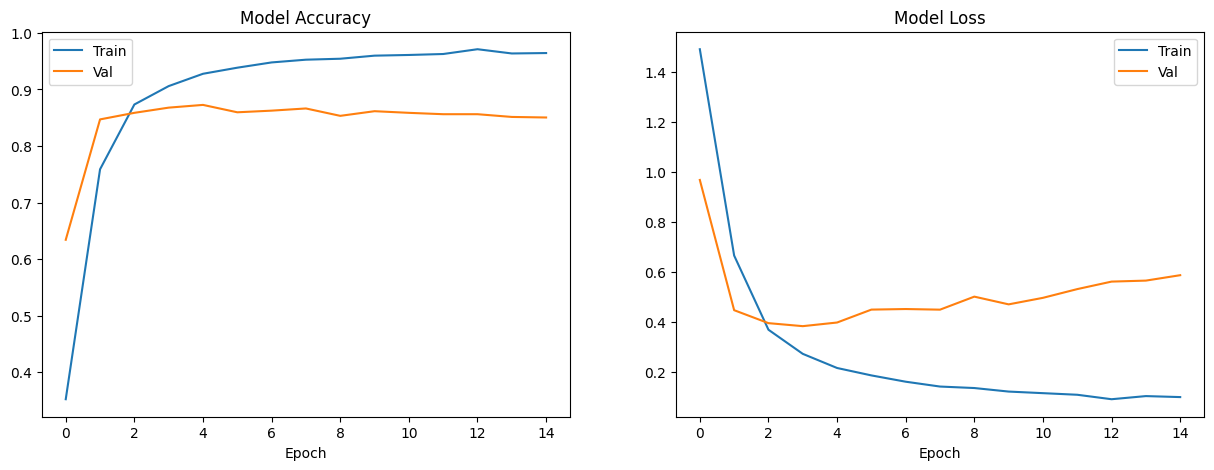

In [71]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2751
Mean length: 61
2532


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 61, 60)         │       165,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 61, 128)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_48 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,081 (824.54 KB)

 Trainable params: 211,081 (824.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.2931 - loss: 1.5832 - val_accuracy: 0.6425 - val_loss: 0.8741
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7235 - loss: 0.7319 - val_accuracy: 0.8312 - val_loss: 0.4698
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8534 - loss: 0.4174 - val_accuracy: 0.8292 - val_loss: 0.4676
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.9024 - loss: 0.2927 - val_accuracy: 0.8481 - val_loss: 0.4398
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9255 - loss: 0.2249 - val_accuracy: 0.8563 - val_loss: 0.4480
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9324 - loss: 0.2026 - val_accuracy: 0.8515 - val_loss: 0.5018
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9469 - loss: 0.1616 - val_accuracy: 0.8418 - val_loss: 0.5213
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9516 - loss: 0.15

Loss:  0.6217363476753235
Accuracy:  0.8413159251213074


ValueError: Unable to synchronously create dataset (name already exists)

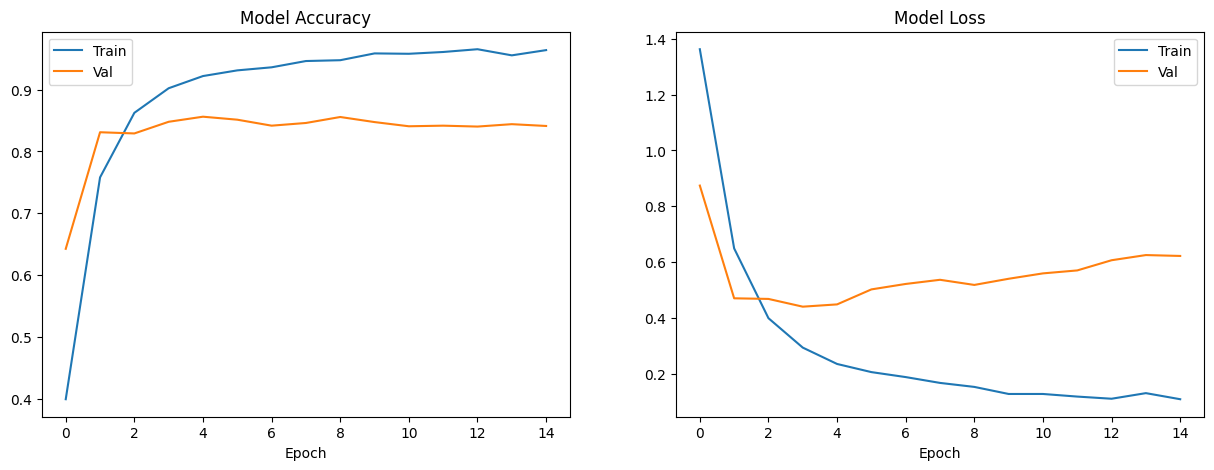

In [72]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

RNN_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2016
Mean length: 52
1887


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 52, 60)         │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 52, 128)        │        16,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 52, 128)        │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_51 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,981 (652.27 KB)

 Trainable params: 166,981 (652.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.2667 - loss: 1.6275 - val_accuracy: 0.7417 - val_loss: 0.6894
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7553 - loss: 0.6499 - val_accuracy: 0.8360 - val_loss: 0.4320
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8642 - loss: 0.3932 - val_accuracy: 0.8520 - val_loss: 0.4180
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8889 - loss: 0.3116 - val_accuracy: 0.8471 - val_loss: 0.4156
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9124 - loss: 0.2584 - val_accuracy: 0.8553 - val_loss: 0.4468
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9237 - loss: 0.2184 - val_accuracy: 0.8645 - val_loss: 0.4470
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9255 - loss: 0.2116 - val_accuracy: 0.8447 - val_loss: 0.4693
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9346 - loss: 0.19

Loss:  0.5517308115959167
Accuracy:  0.8471214175224304


ValueError: Unable to synchronously create dataset (name already exists)

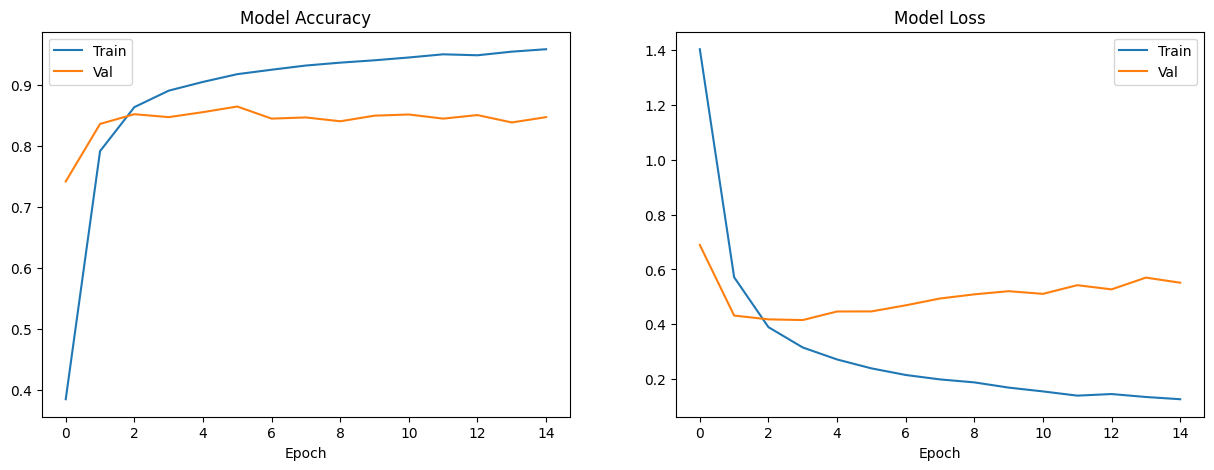

In [73]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

RNN_model(vocab_size, pad_train, pad_test, 'withproc_stem')

#### Conv 1D

In [110]:
def Conv1D_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    # Create Conv1D model for text classification
    conv1d = Sequential(name="Conv1D")
    conv1d.add(Embedding(vocab_size, embedding_dim))
    conv1d.add(Conv1D(128, 5))
    conv1d.add(GlobalMaxPooling1D())
    conv1d.add(Dense(64, activation='relu'))
    conv1d.add(Dense(5, activation='softmax'))

    conv1d.build(input_shape=(None, pad_train.shape[1]))

    print(conv1d.summary())

    conv1d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = conv1d.fit(
        pad_train, 
        train_labels, 
        epochs=15,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(conv1d, history, pad_test, test_labels)
    conv1d.save('Models/Conv1D/conv_'+ proc_type + '.pkl')


**Without Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 4631
Mean length: 90
4146


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 90, 60)         │       277,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 86, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,969 (1.24 MB)

 Trainable params: 324,969 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5615 - loss: 1.1218 - val_accuracy: 0.8684 - val_loss: 0.3501
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9165 - loss: 0.2436 - val_accuracy: 0.8950 - val_loss: 0.2864
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9543 - loss: 0.1338 - val_accuracy: 0.8892 - val_loss: 0.2937
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9773 - loss: 0.0768 - val_accuracy: 0.9028 - val_loss: 0.2952
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9873 - loss: 0.0445 - val_accuracy: 0.8950 - val_loss: 0.3253
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9941 - loss: 0.0246 - val_accuracy: 0.8897 - val_loss: 0.3670
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9961 - loss: 0.0155 - val_accuracy: 0.8926 - val_loss: 0.3896
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9973 - loss: 0.0124 - val

Loss:  0.6070443391799927
Accuracy:  0.8921141624450684


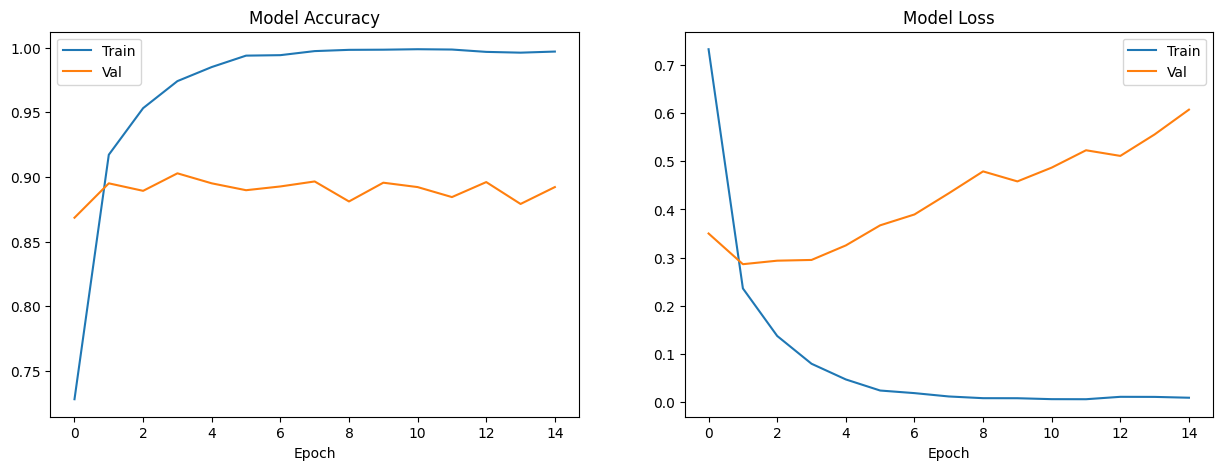

In [111]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input'], test['User_input'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2970
Mean length: 62
2731


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ (None, 62, 60)         │       178,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 58, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,309 (880.11 KB)

 Trainable params: 225,309 (880.11 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5939 - loss: 1.0687 - val_accuracy: 0.8703 - val_loss: 0.3289
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9147 - loss: 0.2383 - val_accuracy: 0.8926 - val_loss: 0.2956
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9498 - loss: 0.1538 - val_accuracy: 0.8897 - val_loss: 0.3014
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9651 - loss: 0.1008 - val_accuracy: 0.8931 - val_loss: 0.3391
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9846 - loss: 0.0574 - val_accuracy: 0.8810 - val_loss: 0.3683
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9859 - loss: 0.0425 - val_accuracy: 0.8911 - val_loss: 0.4183
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9920 - loss: 0.0263 - val_accuracy: 0.8824 - val_loss: 0.4615
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9940 - loss: 0.0202 - val_ac

Loss:  0.6556001901626587
Accuracy:  0.8814707398414612


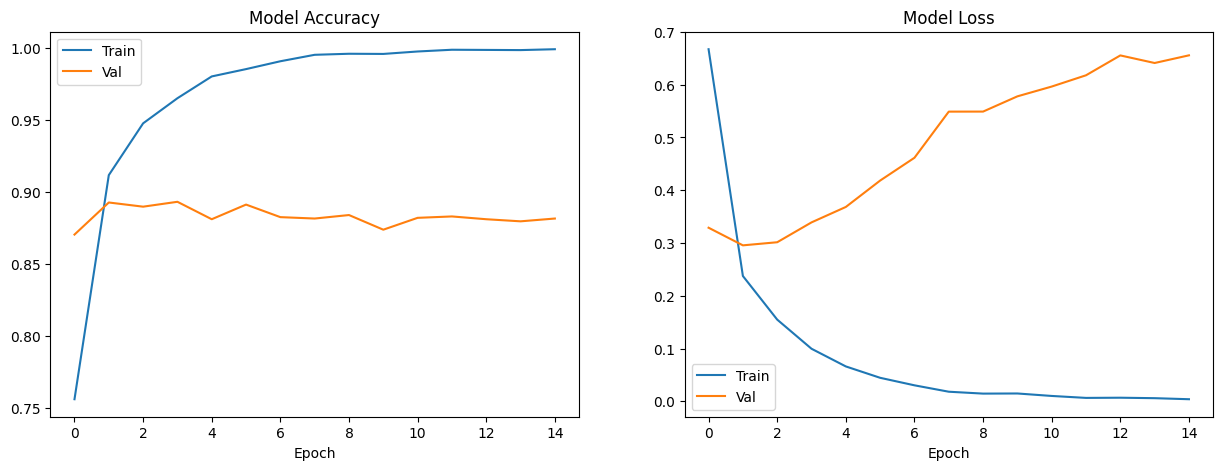

In [112]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2751
Mean length: 61
2532


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)        │ (None, 61, 60)         │       165,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 57, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,169 (828.79 KB)

 Trainable params: 212,169 (828.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5940 - loss: 1.0878 - val_accuracy: 0.8602 - val_loss: 0.3579
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9076 - loss: 0.2549 - val_accuracy: 0.8747 - val_loss: 0.3215
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9449 - loss: 0.1615 - val_accuracy: 0.8810 - val_loss: 0.3378
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9646 - loss: 0.1083 - val_accuracy: 0.8810 - val_loss: 0.3654
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9809 - loss: 0.0671 - val_accuracy: 0.8829 - val_loss: 0.3794
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9856 - loss: 0.0448 - val_accuracy: 0.8766 - val_loss: 0.4444
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9911 - loss: 0.0331 - val_accuracy: 0.8761 - val_loss: 0.4826
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9951 - loss: 0.0180 - val_

Loss:  0.7303935289382935
Accuracy:  0.8684083223342896


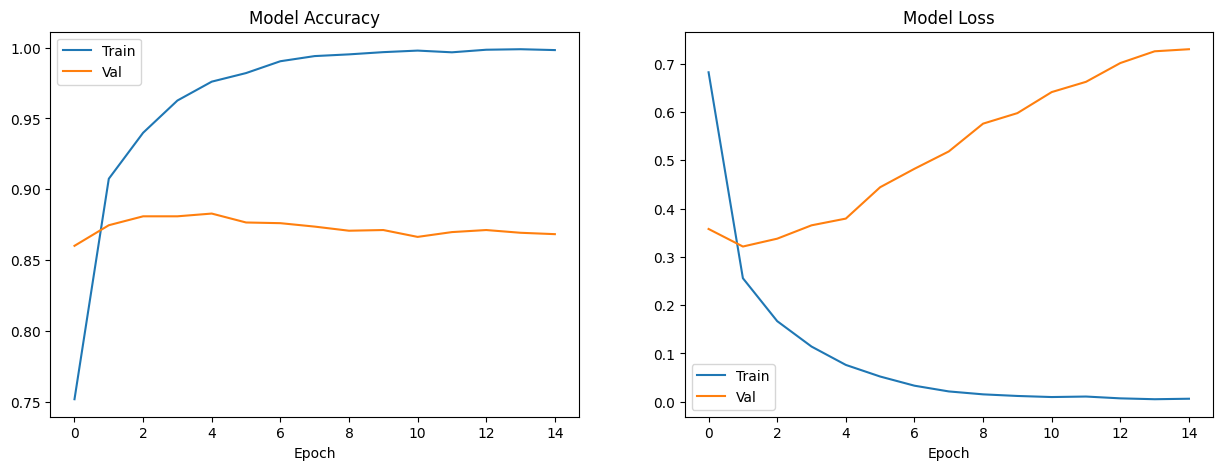

In [113]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(tokenizer, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2016
Mean length: 52
1887


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ (None, 52, 60)         │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 48, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,069 (656.52 KB)

 Trainable params: 168,069 (656.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5938 - loss: 1.0932 - val_accuracy: 0.8423 - val_loss: 0.3728
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8977 - loss: 0.2702 - val_accuracy: 0.8747 - val_loss: 0.3245
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9450 - loss: 0.1661 - val_accuracy: 0.8761 - val_loss: 0.3237
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9573 - loss: 0.1239 - val_accuracy: 0.8752 - val_loss: 0.3496
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9773 - loss: 0.0782 - val_accuracy: 0.8786 - val_loss: 0.3972
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9826 - loss: 0.0555 - val_accuracy: 0.8791 - val_loss: 0.4159
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9910 - loss: 0.0339 - val_accuracy: 0.8776 - val_loss: 0.4721
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9922 - loss: 0.0270 - val_a

Loss:  0.670488715171814
Accuracy:  0.8761489987373352


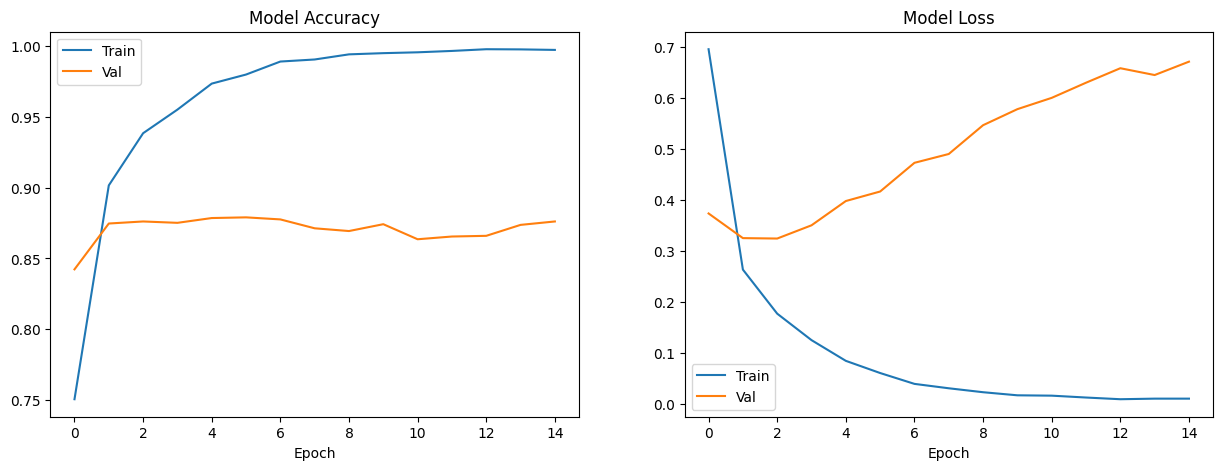

In [114]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_stem')

#### LSTM

In [117]:
def LSTM_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    # Create LSTM model for text classification
    lstm = Sequential(name="LSTM")
    lstm.add(Embedding(vocab_size, embedding_dim))
    lstm.add(LSTM(32))
    lstm.add(Dropout(0.4))
    lstm.add(Dense(5, activation='softmax'))

    lstm.build(input_shape=(None, pad_train.shape[1]))

    print(lstm.summary())

    lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = lstm.fit(
        pad_train, 
        train_labels, 
        epochs=15,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(lstm, history, pad_test, test_labels)
    lstm.save('Models/LSTM/LSTM_'+ proc_type + '.pkl')

**Without Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 4631
Mean length: 90
4146


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_38 (Embedding)        │ (None, 90, 60)         │       277,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,929 (1.11 MB)

 Trainable params: 289,929 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4369 - loss: 1.3102 - val_accuracy: 0.8079 - val_loss: 0.5298
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8473 - loss: 0.4224 - val_accuracy: 0.8573 - val_loss: 0.3840
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9159 - loss: 0.2614 - val_accuracy: 0.8684 - val_loss: 0.3458
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9397 - loss: 0.1954 - val_accuracy: 0.8737 - val_loss: 0.3569
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9544 - loss: 0.1599 - val_accuracy: 0.8703 - val_loss: 0.3824
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9625 - loss: 0.1243 - val_accuracy: 0.8771 - val_loss: 0.3557
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9681 - loss: 0.1112 - val_accuracy: 0.8791 - val_loss: 0.3866
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9739 - loss: 0.0913 - va

Loss:  0.5451188683509827
Accuracy:  0.8761489987373352


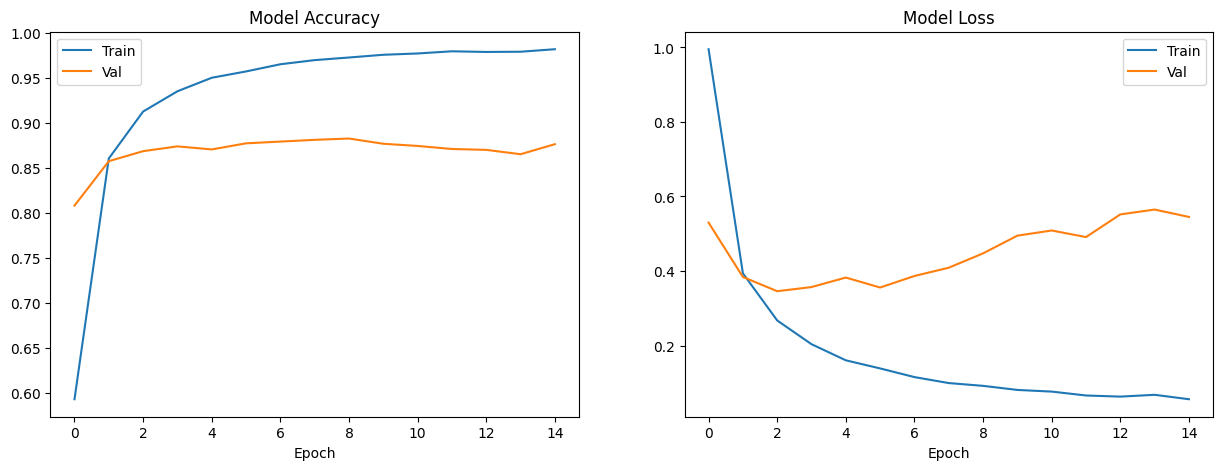

In [118]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input'], test['User_input'])

LSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2970
Mean length: 62
2731


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)        │ (None, 62, 60)         │       178,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,269 (743.24 KB)

 Trainable params: 190,269 (743.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4528 - loss: 1.3037 - val_accuracy: 0.7789 - val_loss: 0.5507
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8425 - loss: 0.4359 - val_accuracy: 0.8732 - val_loss: 0.3448
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9113 - loss: 0.2700 - val_accuracy: 0.8868 - val_loss: 0.3200
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9240 - loss: 0.2254 - val_accuracy: 0.8868 - val_loss: 0.3144
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9481 - loss: 0.1716 - val_accuracy: 0.8921 - val_loss: 0.3094
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9440 - loss: 0.1654 - val_accuracy: 0.8849 - val_loss: 0.3232
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9574 - loss: 0.1408 - val_accuracy: 0.8853 - val_loss: 0.3624
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9570 - loss: 0.1317 - val

Loss:  0.5103368759155273
Accuracy:  0.8688921332359314


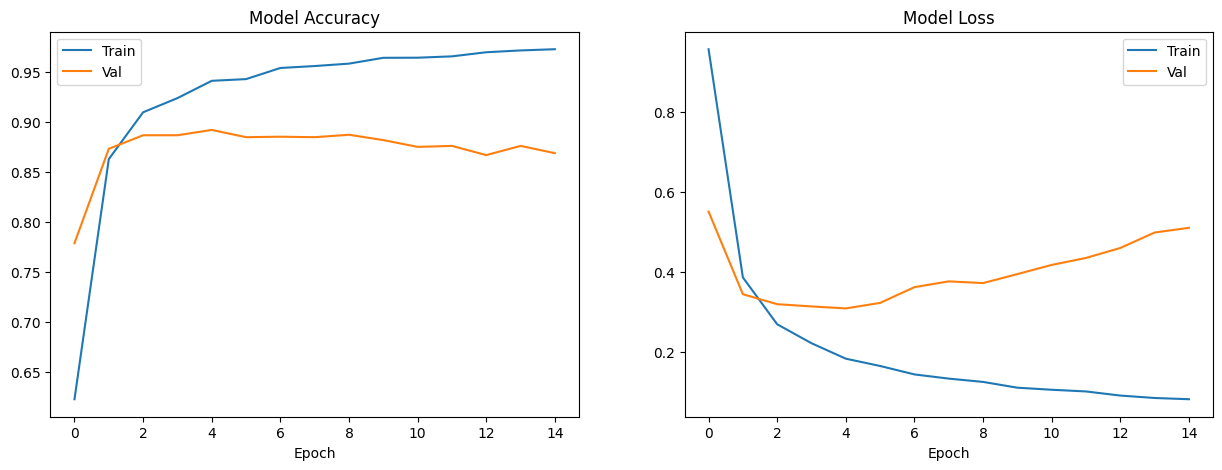

In [119]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2751
Mean length: 61
2532


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_40 (Embedding)        │ (None, 61, 60)         │       165,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,129 (691.91 KB)

 Trainable params: 177,129 (691.91 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4726 - loss: 1.2937 - val_accuracy: 0.8326 - val_loss: 0.4524
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8699 - loss: 0.3880 - val_accuracy: 0.8747 - val_loss: 0.3444
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9057 - loss: 0.2785 - val_accuracy: 0.8800 - val_loss: 0.3218
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9264 - loss: 0.2167 - val_accuracy: 0.8791 - val_loss: 0.3308
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9375 - loss: 0.1851 - val_accuracy: 0.8776 - val_loss: 0.3677
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9452 - loss: 0.1672 - val_accuracy: 0.8791 - val_loss: 0.3647
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9513 - loss: 0.1470 - val_accuracy: 0.8742 - val_loss: 0.4205
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9524 - loss: 0.1414 - val

Loss:  0.5820496082305908
Accuracy:  0.8558297157287598


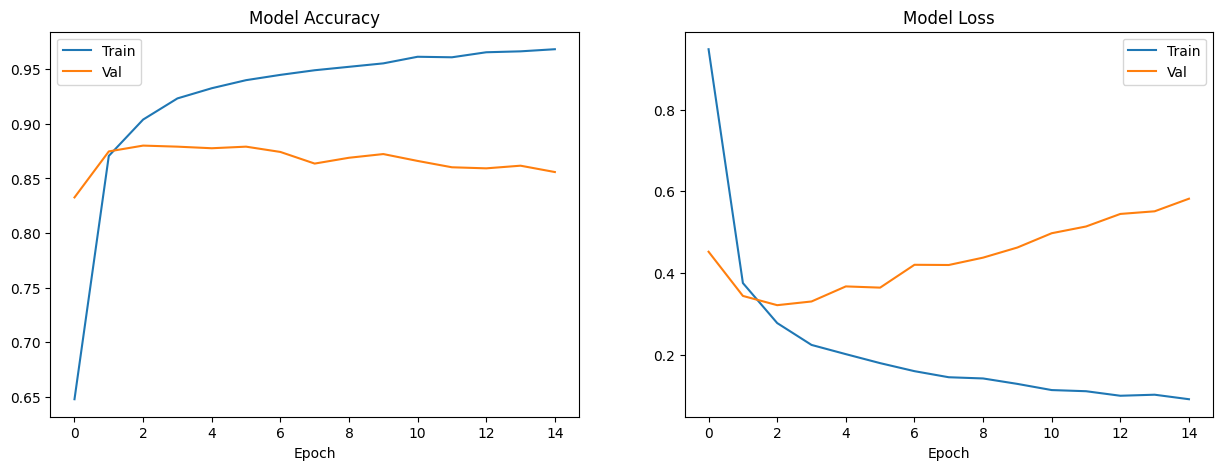

In [120]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2016
Mean length: 52
1887


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_41 (Embedding)        │ (None, 52, 60)         │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,029 (519.64 KB)

 Trainable params: 133,029 (519.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4531 - loss: 1.3407 - val_accuracy: 0.8283 - val_loss: 0.4963
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8517 - loss: 0.4440 - val_accuracy: 0.8703 - val_loss: 0.3546
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9041 - loss: 0.3041 - val_accuracy: 0.8655 - val_loss: 0.3497
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9157 - loss: 0.2526 - val_accuracy: 0.8791 - val_loss: 0.3323
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9236 - loss: 0.2262 - val_accuracy: 0.8699 - val_loss: 0.3393
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9371 - loss: 0.2038 - val_accuracy: 0.8766 - val_loss: 0.3419
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9388 - loss: 0.1804 - val_accuracy: 0.8708 - val_loss: 0.4129
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9431 - loss: 0.1773 - val

Loss:  0.48959052562713623
Accuracy:  0.8572810888290405


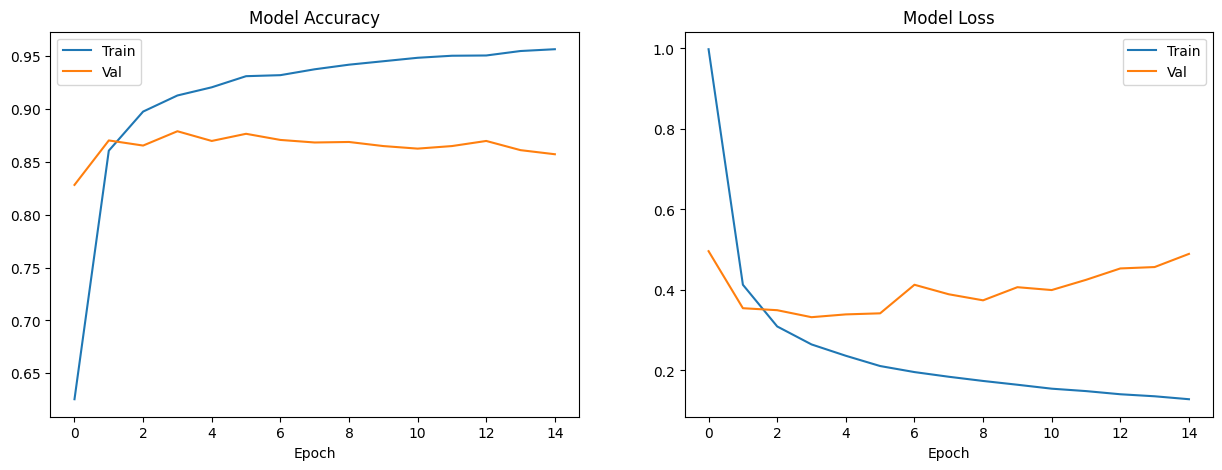

In [121]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')

#### BILSTM

In [124]:
def BiLSTM_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    # Create LSTM model for text classification
    blstm = Sequential(name="Bi_LSTM")
    blstm.add(Embedding(vocab_size, embedding_dim))
    blstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
    blstm.add(Dropout(0.4))
    blstm.add(Bidirectional(LSTM(32)))
    blstm.add(Dropout(0.2))
    blstm.add(Dense(64, activation='relu'))
    blstm.add(Dropout(0.1))
    blstm.add(Dense(5, activation='softmax'))

    blstm.build(input_shape=(None, pad_train.shape[1]))

    print(blstm.summary())

    blstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = blstm.fit(
        pad_train, 
        train_labels, 
        epochs=15,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(blstm, history, pad_test, test_labels)
    blstm.save('Models/BILSTM/BILSTM_'+ proc_type + '.pkl')

**Without Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 4631
Mean length: 90
4146


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_42 (Embedding)        │ (None, 90, 60)         │       277,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 90, 128)        │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,561 (1.48 MB)

 Trainable params: 387,561 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - accuracy: 0.4415 - loss: 1.2254 - val_accuracy: 0.8534 - val_loss: 0.4074
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.8787 - loss: 0.3309 - val_accuracy: 0.8800 - val_loss: 0.3445
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.9261 - loss: 0.2140 - val_accuracy: 0.8742 - val_loss: 0.3511
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.9481 - loss: 0.1646 - val_accuracy: 0.8810 - val_loss: 0.3535
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.9587 - loss: 0.1343 - val_accuracy: 0.8839 - val_loss: 0.3753
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9640 - loss: 0.1143 - val_accuracy: 0.8829 - val_loss: 0.4516
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9648 - loss: 0.1084 - val_accuracy: 0.8902 - val_loss: 0.4091
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9716 - loss: 0.0

Loss:  0.5464988350868225
Accuracy:  0.8746976256370544


ValueError: Unable to synchronously create dataset (name already exists)

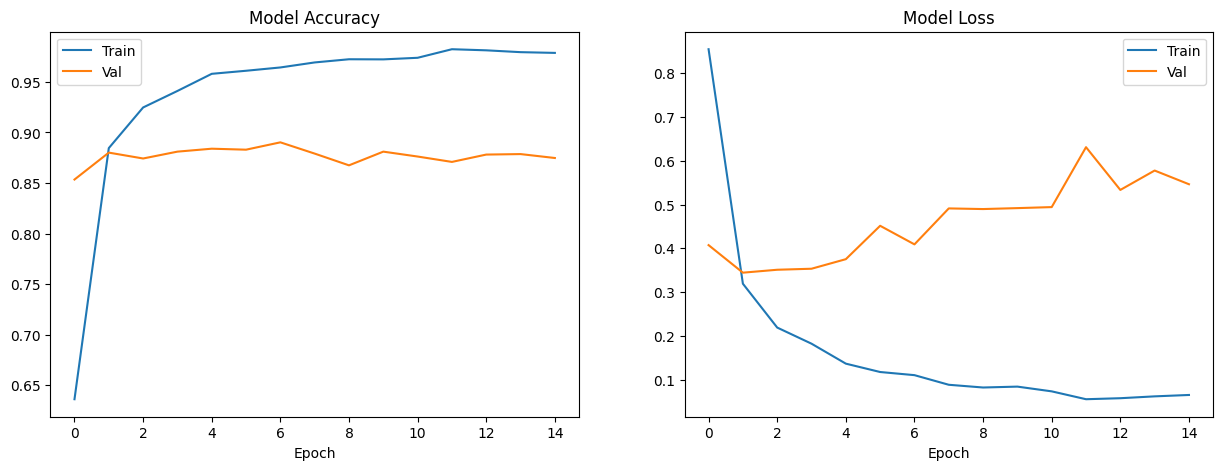

In [125]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input'], test['User_input'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2970
Mean length: 62
2731


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_43 (Embedding)        │ (None, 62, 60)         │       178,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 62, 128)        │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,901 (1.10 MB)

 Trainable params: 287,901 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.4618 - loss: 1.2165 - val_accuracy: 0.8336 - val_loss: 0.4449
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.8677 - loss: 0.3617 - val_accuracy: 0.8655 - val_loss: 0.3724
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.9069 - loss: 0.2635 - val_accuracy: 0.8761 - val_loss: 0.3442
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.9305 - loss: 0.2094 - val_accuracy: 0.8771 - val_loss: 0.3569
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9395 - loss: 0.1776 - val_accuracy: 0.8761 - val_loss: 0.3894
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9452 - loss: 0.1619 - val_accuracy: 0.8858 - val_loss: 0.3454
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9538 - loss: 0.1486 - val_accuracy: 0.8757 - val_loss: 0.3886
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9506 - loss: 0.13

Loss:  0.574897825717926
Accuracy:  0.8659893274307251


ValueError: Unable to synchronously create dataset (name already exists)

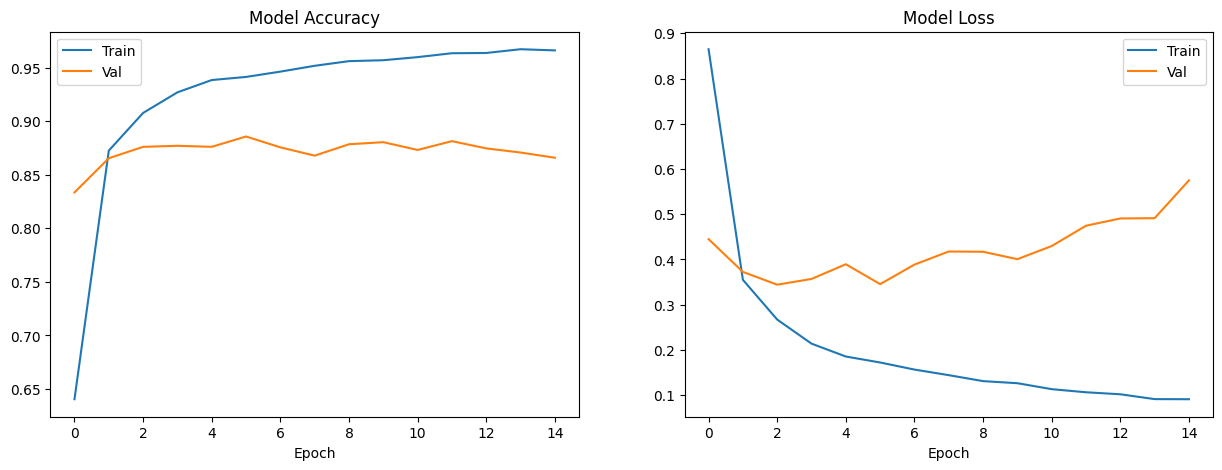

In [126]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2751
Mean length: 61
2532


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_44 (Embedding)        │ (None, 61, 60)         │       165,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 61, 128)        │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 61, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,761 (1.05 MB)

 Trainable params: 274,761 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.4664 - loss: 1.2157 - val_accuracy: 0.8355 - val_loss: 0.4198
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8584 - loss: 0.3834 - val_accuracy: 0.8679 - val_loss: 0.3642
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9071 - loss: 0.2558 - val_accuracy: 0.8674 - val_loss: 0.3728
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9252 - loss: 0.2095 - val_accuracy: 0.8781 - val_loss: 0.3664
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9371 - loss: 0.1794 - val_accuracy: 0.8781 - val_loss: 0.3801
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.9422 - loss: 0.1592 - val_accuracy: 0.8742 - val_loss: 0.4144
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9458 - loss: 0.1607 - val_accuracy: 0.8694 - val_loss: 0.4605
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9556 - loss: 0.13

Loss:  0.6106784343719482
Accuracy:  0.8577648997306824


ValueError: Unable to synchronously create dataset (name already exists)

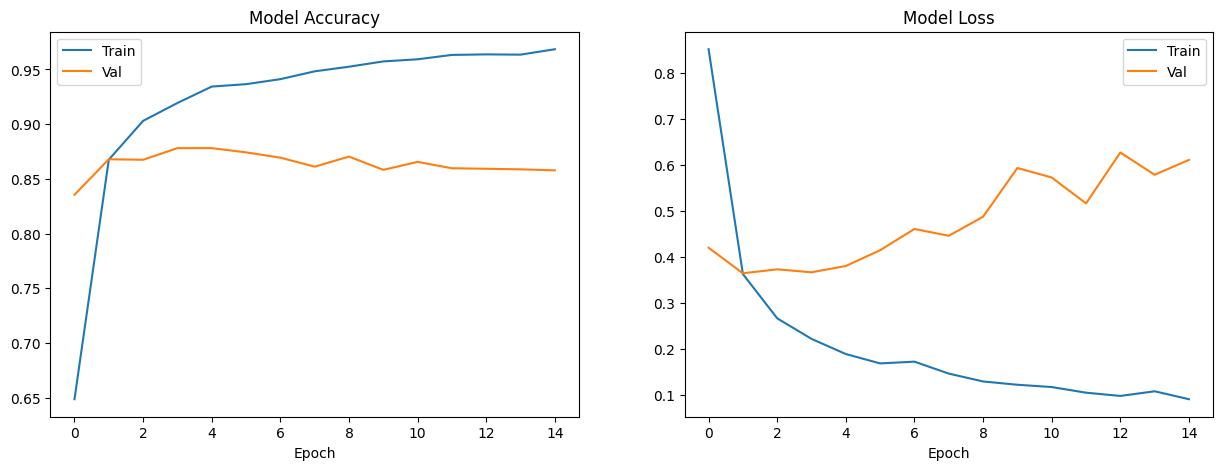

In [127]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2016
Mean length: 52
1887


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_46 (Embedding)        │ (None, 52, 60)         │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 52, 128)        │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,661 (901.02 KB)

 Trainable params: 230,661 (901.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4587 - loss: 1.2257 - val_accuracy: 0.8220 - val_loss: 0.4780
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.8489 - loss: 0.4189 - val_accuracy: 0.8258 - val_loss: 0.4592
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.8843 - loss: 0.3288 - val_accuracy: 0.8505 - val_loss: 0.4024
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8953 - loss: 0.2886 - val_accuracy: 0.8524 - val_loss: 0.4148
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9158 - loss: 0.2552 - val_accuracy: 0.8568 - val_loss: 0.4218
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9225 - loss: 0.2195 - val_accuracy: 0.8597 - val_loss: 0.4096
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9356 - loss: 0.1868 - val_accuracy: 0.8568 - val_loss: 0.4206
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9396 - loss: 0.16

Loss:  0.5107753276824951
Accuracy:  0.8519593477249146


ValueError: Unable to synchronously create dataset (name already exists)

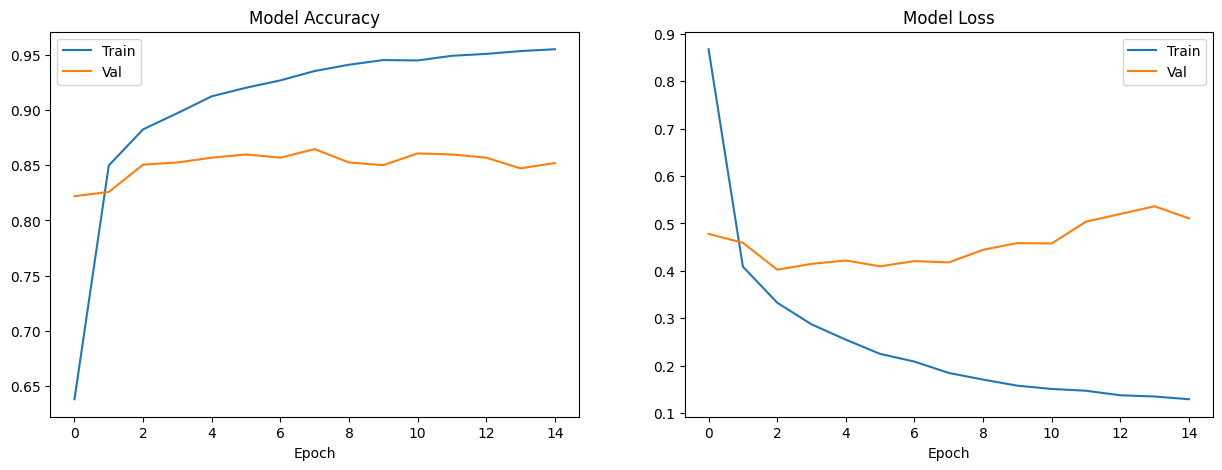

In [129]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')